# Autocorrelations

--------------------------------------------------------------------
### TODO:
* [x] Generate multiple chain lengths and deal with loading in from multiple `samples_history` files.
* [x] Implement the same logic for `observables` as for `samples_history`.
* [ ] Modify remainder of code below to deal with case where `samples` and `observables` are dictionaries with keys specifying the length of the MCMC chain.
* [ ] Re-run the cells below for the remainder of `HMC` directory to get ESS values for comparing against ESS from L2HMC.
* [ ] Try training sampler for >> 1000 steps and running the trained sampler for a variety of different chain lengths to see what the integrated autocorrelation time approaches as  $N_{steps} \longrightarrow \infty$.
--------------------------------------------------------------------

## Imports

In [2]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import autocorrelation_plot
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [4]:
from lattice.gauge_lattice import GaugeLattice
from l2hmc_eager import gauge_dynamics_eager as gde
from u1_model_eager import GaugeModelEager, train_one_iter
from gauge_model import GaugeModel

import utils.gauge_model_helpers as helpers
from utils.autocorr import *
from utils.gauge_observables import *
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

%autoreload 2
#%matplotlib notebook
%matplotlib inline

Using TensorFlow backend.


In [5]:
def check_else_make_dir(d):
    if not os.path.isdir(d):
        print(f"Making directory: {d}")
        os.makedirs(d)

## Using helpers from: `utils/gauge_observables.py`

Making directory: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/figures/autocorrelation_plots/mpl_autocorr_dir.
Making directory: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/figures/autocorrelation_plots/pandas_autocorr_plots.
Loading samples from: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/run_info/samples_history.pkl.
step: 0 time/step: 0.3149 avg action:  249   avg plaquette: 0.5136 top charges: 


[0, 3, -1, -2, 0, -1, 0, -1, 1, 0]


step: 1 time/step: 0.2651 avg action: 150.7  avg plaquette: 0.7056 top charges: 


[0, 0, 0, -1, 0, 0, 1, 0, 0, 0]


step: 2 time/step: 0.313  avg action: 98.14  avg plaquette: 0.8083 top charges: 


[0, 1, 0, -2, 0, -1, 0, -1, 1, 0]


step: 3 time/step: 0.7189 avg action: 71.79  avg plaquette: 0.8598 top charges: 


[0, 2, 1, -2, 1, -1, 0, -1, 0, 0]


step: 4 time/step: 0.4481 avg action: 55.11  avg plaquette: 0.8924 top charges: 


[

step: 65 time/step: 0.2835 avg action: 34.97  avg plaquette: 0.9317 top charges: 


[0, 2, 0, 0, 0, -1, 0, -1, 1, -1]


step: 66 time/step: 0.3524 avg action: 34.15  avg plaquette: 0.9333 top charges: 


[0, 2, 1, 0, 1, -1, 0, 0, 1, -1]


step: 67 time/step: 0.2963 avg action: 33.76  avg plaquette: 0.9341 top charges: 


[0, 1, 0, 0, 1, -1, 0, -1, 1, 0]


step: 68 time/step: 0.3005 avg action: 36.31  avg plaquette: 0.9291 top charges: 


[0, 1, 0, -1, 0, -1, 0, -1, 1, -1]


step: 69 time/step: 0.2996 avg action: 35.55  avg plaquette: 0.9306 top charges: 


[0, 1, 1, 0, 0, -1, 0, 0, 1, -1]


step: 70 time/step: 0.302  avg action: 34.93  avg plaquette: 0.9318 top charges: 


[0, 1, 1, 0, 0, -1, -1, 0, 1, -1]


step: 71 time/step: 0.4184 avg action:  35.7  avg plaquette: 0.9303 top charges: 


[0, 2, 0, 0, 0, 0, -1, 0, 1, 0]


step: 72 time/step: 0.4939 avg action: 34.48  avg plaquette: 0.9327 top charges: 


[0, 1, 1, 0, 0, 0, 0, -1, 1, -1]


step: 73 time/step: 0.3197 avg action: 35.96 

step: 134 time/step: 0.2844 avg action: 37.08  avg plaquette: 0.9276 top charges: 


[0, 1, 0, 0, 1, 0, 0, -1, 0, -1]


step: 135 time/step: 0.3294 avg action: 33.97  avg plaquette: 0.9336 top charges: 


[0, 1, 0, 0, 0, 0, 0, -1, 0, 0]


step: 136 time/step: 0.3042 avg action: 39.15  avg plaquette: 0.9235 top charges: 


[0, 1, 1, 0, 1, 0, -1, -1, 0, -1]


step: 137 time/step: 0.3208 avg action: 36.54  avg plaquette: 0.9286 top charges: 


[0, 1, 1, -1, 0, 0, 0, 0, 0, 0]


step: 138 time/step: 0.3496 avg action: 37.58  avg plaquette: 0.9266 top charges: 


[0, 1, 1, -1, 1, 0, 0, -1, 0, 0]


step: 139 time/step: 0.4096 avg action: 35.02  avg plaquette: 0.9316 top charges: 


[0, 1, 1, 0, 1, 0, 0, 0, 1, 0]


step: 140 time/step: 0.5002 avg action:  37.4  avg plaquette: 0.927  top charges: 


[0, 1, 1, 0, 1, -1, 0, 0, 1, -1]


step: 141 time/step: 0.3335 avg action: 34.61  avg plaquette: 0.9324 top charges: 


[0, 2, 1, 0, 0, -1, 0, -1, 0, 0]


step: 142 time/step: 0.3035 avg action: 36.

step: 203 time/step: 0.7497 avg action: 33.15  avg plaquette: 0.9352 top charges: 


[0, 1, 1, 0, 0, -1, 0, -1, 1, -1]


step: 204 time/step: 0.4996 avg action: 33.75  avg plaquette: 0.9341 top charges: 


[0, 1, 0, 0, 0, 0, 0, -1, 1, 0]


step: 205 time/step: 0.299  avg action: 34.22  avg plaquette: 0.9332 top charges: 


[0, 2, 0, -1, 1, -1, -1, -1, 1, -1]


step: 206 time/step: 0.3273 avg action:  36.2  avg plaquette: 0.9293 top charges: 


[0, 1, 1, -1, 0, -1, 0, -1, 0, -1]


step: 207 time/step: 0.3158 avg action: 37.21  avg plaquette: 0.9273 top charges: 


[0, 1, 1, 0, 1, -1, -1, -1, 1, -1]


step: 208 time/step: 0.3259 avg action: 33.24  avg plaquette: 0.9351 top charges: 


[0, 2, 1, 0, 0, 0, -1, -1, 0, 0]


step: 209 time/step: 0.322  avg action: 34.92  avg plaquette: 0.9318 top charges: 


[0, 2, 0, 0, 0, -1, -1, 0, 1, 0]


step: 210 time/step: 0.3021 avg action: 37.99  avg plaquette: 0.9258 top charges: 


[0, 1, 1, 0, 0, -1, 0, 0, 0, 0]


step: 211 time/step: 0.4026 avg ac

step: 271 time/step: 0.2773 avg action: 33.76  avg plaquette: 0.9341 top charges: 


[0, 2, 0, 0, 1, -1, 0, 0, 1, 0]


step: 272 time/step: 0.2831 avg action: 36.09  avg plaquette: 0.9295 top charges: 


[0, 2, 0, -1, 0, 0, 0, 0, 1, -1]


step: 273 time/step: 0.301  avg action: 34.67  avg plaquette: 0.9323 top charges: 


[0, 1, 1, 0, 0, -1, 0, 0, 0, 0]


step: 274 time/step: 0.3166 avg action: 34.49  avg plaquette: 0.9326 top charges: 


[0, 2, 0, 0, 0, -1, 0, 0, 1, 0]


step: 275 time/step: 0.2686 avg action: 36.07  avg plaquette: 0.9295 top charges: 


[0, 2, 0, 0, 0, -1, -1, 0, 1, 0]


step: 276 time/step: 0.3431 avg action: 33.56  avg plaquette: 0.9344 top charges: 


[0, 1, 0, 0, 1, -1, 0, 0, 0, 0]


step: 277 time/step: 0.3299 avg action: 35.89  avg plaquette: 0.9299 top charges: 


[0, 1, 1, -1, 0, -1, -1, -1, 1, 0]


step: 278 time/step: 0.331  avg action: 35.94  avg plaquette: 0.9298 top charges: 


[0, 2, 0, 0, 1, 0, -1, -1, 1, 0]


step: 279 time/step: 0.371  avg action:  3

step: 339 time/step: 0.3561 avg action: 36.12  avg plaquette: 0.9295 top charges: 


[0, 2, 1, -1, 0, 0, -1, -1, 0, 0]


step: 340 time/step: 0.3841 avg action: 34.26  avg plaquette: 0.9331 top charges: 


[0, 2, 1, 0, 0, 0, -1, -1, 0, -1]


step: 341 time/step:  0.42  avg action: 36.75  avg plaquette: 0.9282 top charges: 


[0, 2, 1, -1, 0, 0, 0, -1, 1, 0]


step: 342 time/step: 0.4298 avg action: 36.59  avg plaquette: 0.9285 top charges: 


[0, 1, 1, -1, 1, -1, -1, 0, 1, -1]


step: 343 time/step: 0.3682 avg action: 32.48  avg plaquette: 0.9366 top charges: 


[0, 2, 0, 0, 1, 0, 0, -1, 1, 0]


step: 344 time/step: 0.3888 avg action: 32.45  avg plaquette: 0.9366 top charges: 


[0, 1, 1, 0, 1, 0, 0, -1, 0, 0]


step: 345 time/step: 0.4272 avg action: 33.81  avg plaquette: 0.934  top charges: 


[0, 2, 1, -1, 0, -1, -1, 0, 0, 0]


step: 346 time/step: 0.4427 avg action:  36.6  avg plaquette: 0.9285 top charges: 


[0, 1, 0, -1, 0, 0, -1, 0, 0, 0]


step: 347 time/step: 0.4072 avg actio

step: 408 time/step: 0.2992 avg action: 36.72  avg plaquette: 0.9283 top charges: 


[0, 1, 1, 0, 1, 0, 0, 0, 0, -1]


step: 409 time/step: 0.297  avg action:  39.7  avg plaquette: 0.9225 top charges: 


[0, 1, 0, -1, 1, -1, -1, 0, 1, 0]


step: 410 time/step: 0.3176 avg action: 38.88  avg plaquette: 0.9241 top charges: 


[0, 2, 1, 0, 1, 0, 0, 0, 0, -1]


step: 411 time/step: 0.3041 avg action: 35.79  avg plaquette: 0.9301 top charges: 


[0, 1, 0, 0, 0, 0, 0, 0, 1, -1]


step: 412 time/step: 0.3292 avg action: 33.57  avg plaquette: 0.9344 top charges: 


[0, 2, 1, 0, 0, 0, 0, 0, 0, -1]


step: 413 time/step: 0.3188 avg action: 37.58  avg plaquette: 0.9266 top charges: 


[0, 2, 1, 0, 1, 0, -1, 0, 1, 0]


step: 414 time/step: 0.3108 avg action: 36.28  avg plaquette: 0.9292 top charges: 


[0, 1, 1, 0, 1, -1, 0, 0, 0, -1]


step: 415 time/step:  0.28  avg action:  35.7  avg plaquette: 0.9303 top charges: 


[0, 2, 1, 0, 1, 0, 0, 0, 1, -1]


step: 416 time/step: 0.3011 avg action: 34.62

step: 476 time/step: 0.3156 avg action: 35.79  avg plaquette: 0.9301 top charges: 


[0, 2, 0, 0, 0, 0, 0, -1, 1, 0]


step: 477 time/step: 0.3119 avg action: 33.46  avg plaquette: 0.9346 top charges: 


[0, 1, 0, -1, 0, -1, 0, 0, 1, -1]


step: 478 time/step: 0.3179 avg action: 36.46  avg plaquette: 0.9288 top charges: 


[0, 1, 1, -1, 0, -1, -1, 0, 0, -1]


step: 479 time/step: 0.3104 avg action: 31.73  avg plaquette: 0.938  top charges: 


[0, 1, 1, 0, 0, -1, -1, 0, 1, -1]


step: 480 time/step: 0.336  avg action: 34.24  avg plaquette: 0.9331 top charges: 


[0, 1, 1, 0, 0, 0, -1, -1, 1, -1]


step: 481 time/step: 0.5198 avg action:  36.1  avg plaquette: 0.9295 top charges: 


[0, 2, 1, -1, 0, -1, 0, 0, 0, -1]


step: 482 time/step: 0.4109 avg action: 35.03  avg plaquette: 0.9316 top charges: 


[0, 1, 1, 0, 1, 0, -1, -1, 0, -1]


step: 483 time/step: 0.3531 avg action: 37.73  avg plaquette: 0.9263 top charges: 


[0, 2, 1, -1, 1, 0, 0, 0, 0, -1]


step: 484 time/step: 0.2994 avg ac

step: 544 time/step: 0.2947 avg action: 34.97  avg plaquette: 0.9317 top charges: 


[0, 2, 1, 0, 0, 0, -1, 0, 1, 0]


step: 545 time/step: 0.3359 avg action: 38.04  avg plaquette: 0.9257 top charges: 


[0, 2, 0, 0, 0, -1, 0, -1, 0, 0]


step: 546 time/step: 0.2999 avg action: 40.32  avg plaquette: 0.9213 top charges: 


[0, 1, 1, -1, 1, -1, 0, -1, 1, -1]


step: 547 time/step: 0.2696 avg action: 36.08  avg plaquette: 0.9295 top charges: 


[0, 1, 0, -1, 0, -1, -1, -1, 1, 0]


step: 548 time/step: 0.3339 avg action: 37.73  avg plaquette: 0.9263 top charges: 


[0, 2, 1, -1, 1, 0, 0, -1, 1, -1]


step: 549 time/step: 0.3896 avg action: 36.54  avg plaquette: 0.9286 top charges: 


[0, 2, 0, 0, 0, -1, 0, -1, 0, -1]


step: 550 time/step: 0.4755 avg action: 35.14  avg plaquette: 0.9314 top charges: 


[0, 2, 0, 0, 1, 0, -1, 0, 1, -1]


step: 551 time/step: 0.305  avg action: 37.34  avg plaquette: 0.9271 top charges: 


[0, 2, 1, -1, 1, 0, 0, 0, 0, 0]


step: 552 time/step: 0.2949 avg acti

step: 612 time/step: 0.3104 avg action: 37.16  avg plaquette: 0.9274 top charges: 


[0, 2, 0, -1, 0, -1, 0, 0, 1, 0]


step: 613 time/step: 0.3897 avg action: 36.47  avg plaquette: 0.9288 top charges: 


[0, 2, 1, -1, 1, 0, 0, 0, 1, 0]


step: 614 time/step: 0.334  avg action:  34.8  avg plaquette: 0.932  top charges: 


[0, 1, 1, 0, 0, -1, 0, -1, 0, -1]


step: 615 time/step: 0.3478 avg action: 35.23  avg plaquette: 0.9312 top charges: 


[0, 2, 0, -1, 0, -1, 0, 0, 1, -1]


step: 616 time/step: 0.3367 avg action: 36.89  avg plaquette: 0.9279 top charges: 


[0, 1, 1, -1, 1, -1, 0, -1, 0, -1]


step: 617 time/step: 0.2996 avg action: 34.87  avg plaquette: 0.9319 top charges: 


[0, 2, 1, -1, 0, -1, 0, 0, 0, -1]


step: 618 time/step: 0.2919 avg action: 35.81  avg plaquette: 0.9301 top charges: 


[0, 1, 0, 0, 0, -1, -1, -1, 0, 0]


step: 619 time/step: 0.4173 avg action: 39.79  avg plaquette: 0.9223 top charges: 


[0, 1, 1, 0, 1, -1, 0, -1, 0, -1]


step: 620 time/step: 0.3025 avg ac

step: 680 time/step: 0.3219 avg action: 36.87  avg plaquette: 0.928  top charges: 


[0, 2, 0, -1, 0, -1, -1, -1, 0, -1]


step: 681 time/step: 0.3385 avg action: 36.54  avg plaquette: 0.9286 top charges: 


[0, 1, 1, 0, 0, -1, 0, 0, 1, -1]


step: 682 time/step: 0.3876 avg action: 35.67  avg plaquette: 0.9303 top charges: 


[0, 2, 1, 0, 1, 0, -1, 0, 1, -1]


step: 683 time/step: 0.2935 avg action: 31.89  avg plaquette: 0.9377 top charges: 


[0, 1, 0, 0, 1, -1, -1, 0, 1, -1]


step: 684 time/step: 0.3506 avg action:  32.9  avg plaquette: 0.9357 top charges: 


[0, 1, 0, -1, 0, -1, -1, 0, 0, 0]


step: 685 time/step: 0.3474 avg action: 35.34  avg plaquette: 0.931  top charges: 


[0, 2, 0, 0, 0, 0, 0, 0, 0, -1]


step: 686 time/step: 0.3051 avg action: 34.67  avg plaquette: 0.9323 top charges: 


[0, 2, 1, -1, 1, 0, 0, -1, 0, -1]


step: 687 time/step: 0.3155 avg action:  33.8  avg plaquette: 0.934  top charges: 


[0, 2, 1, -1, 0, -1, 0, -1, 1, -1]


step: 688 time/step: 0.2974 avg a

step: 748 time/step: 0.3347 avg action: 37.56  avg plaquette: 0.9266 top charges: 


[0, 2, 1, 0, 0, -1, -1, -1, 1, 0]


step: 749 time/step: 0.3089 avg action:   36   avg plaquette: 0.9297 top charges: 


[0, 1, 0, 0, 1, 0, -1, -1, 0, -1]


step: 750 time/step: 0.2896 avg action: 34.04  avg plaquette: 0.9335 top charges: 


[0, 2, 1, -1, 0, 0, -1, 0, 0, -1]


step: 751 time/step: 0.325  avg action: 35.96  avg plaquette: 0.9298 top charges: 


[0, 2, 1, 0, 0, 0, -1, -1, 0, 0]


step: 752 time/step: 0.3017 avg action: 36.92  avg plaquette: 0.9279 top charges: 


[0, 2, 1, 0, 1, -1, -1, 0, 0, 0]


step: 753 time/step: 0.3005 avg action: 33.55  avg plaquette: 0.9345 top charges: 


[0, 1, 0, -1, 0, -1, 0, 0, 0, -1]


step: 754 time/step: 0.3185 avg action: 35.85  avg plaquette:  0.93  top charges: 


[0, 2, 0, 0, 1, -1, 0, 0, 1, 0]


step: 755 time/step: 0.3206 avg action: 36.19  avg plaquette: 0.9293 top charges: 


[0, 1, 0, -1, 1, 0, -1, -1, 1, 0]


step: 756 time/step: 0.3144 avg acti

step: 816 time/step: 0.3008 avg action: 34.14  avg plaquette: 0.9333 top charges: 


[0, 2, 0, -1, 0, 0, -1, -1, 1, -1]


step: 817 time/step: 0.2807 avg action: 36.91  avg plaquette: 0.9279 top charges: 


[0, 2, 1, -1, 1, -1, 0, -1, 1, -1]


step: 818 time/step: 0.3658 avg action: 35.37  avg plaquette: 0.9309 top charges: 


[0, 1, 1, -1, 0, 0, 0, -1, 0, -1]


step: 819 time/step: 0.3051 avg action: 37.95  avg plaquette: 0.9259 top charges: 


[0, 2, 1, 0, 0, -1, 0, 0, 1, 0]


step: 820 time/step: 0.3342 avg action: 36.44  avg plaquette: 0.9288 top charges: 


[0, 2, 1, 0, 0, 0, 0, 0, 1, -1]


step: 821 time/step: 0.5861 avg action: 33.06  avg plaquette: 0.9354 top charges: 


[0, 1, 1, -1, 0, -1, 0, 0, 1, 0]


step: 822 time/step: 0.8469 avg action: 31.99  avg plaquette: 0.9375 top charges: 


[0, 1, 1, -1, 0, 0, 0, 0, 1, -1]


step: 823 time/step:  1.36  avg action: 34.48  avg plaquette: 0.9327 top charges: 


[0, 2, 0, -1, 0, -1, 0, -1, 1, -1]


step: 824 time/step: 1.215  avg act

step: 885 time/step: 0.2841 avg action: 35.78  avg plaquette: 0.9301 top charges: 


[0, 2, 1, -1, 0, -1, -1, -1, 1, -1]


step: 886 time/step: 0.2868 avg action: 35.22  avg plaquette: 0.9312 top charges: 


[0, 1, 0, 0, 0, -1, -1, -1, 0, 0]


step: 887 time/step: 0.2974 avg action: 39.87  avg plaquette: 0.9221 top charges: 


[0, 2, 0, -1, 0, -1, -1, -1, 1, -1]


step: 888 time/step: 0.2822 avg action: 37.89  avg plaquette: 0.926  top charges: 


[0, 2, 0, 0, 0, 0, 0, -1, 1, -1]


step: 889 time/step: 0.2727 avg action: 35.14  avg plaquette: 0.9314 top charges: 


[0, 1, 1, 0, 1, -1, -1, -1, 0, -1]


step: 890 time/step: 0.3585 avg action: 34.58  avg plaquette: 0.9325 top charges: 


[0, 1, 0, 0, 0, 0, -1, 0, 0, 0]


step: 891 time/step: 0.3997 avg action: 35.77  avg plaquette: 0.9301 top charges: 


[0, 2, 1, 0, 0, -1, -1, 0, 0, -1]


step: 892 time/step: 0.2549 avg action: 37.01  avg plaquette: 0.9277 top charges: 


[0, 2, 1, -1, 1, -1, 0, 0, 0, -1]


step: 893 time/step: 0.3189 av

step: 953 time/step: 0.2625 avg action: 32.29  avg plaquette: 0.9369 top charges: 


[0, 2, 1, 0, 0, 0, 0, -1, 1, -1]


step: 954 time/step: 0.3274 avg action: 36.73  avg plaquette: 0.9283 top charges: 


[0, 1, 0, 0, 0, -1, 0, -1, 0, -1]


step: 955 time/step: 0.2756 avg action: 34.19  avg plaquette: 0.9332 top charges: 


[0, 2, 1, 0, 0, -1, 0, 0, 0, 0]


step: 956 time/step: 0.2607 avg action: 35.27  avg plaquette: 0.9311 top charges: 


[0, 1, 0, 0, 0, 0, 0, -1, 0, 0]


step: 957 time/step: 0.3167 avg action: 35.81  avg plaquette: 0.9301 top charges: 


[0, 2, 0, -1, 0, 0, 0, -1, 0, -1]


step: 958 time/step: 0.2428 avg action: 34.68  avg plaquette: 0.9323 top charges: 


[0, 2, 0, -1, 1, -1, -1, 0, 1, -1]


step: 959 time/step: 0.2141 avg action: 33.75  avg plaquette: 0.9341 top charges: 


[0, 1, 1, 0, 0, -1, -1, -1, 0, -1]


step: 960 time/step: 0.2455 avg action: 33.45  avg plaquette: 0.9347 top charges: 


[0, 1, 0, 0, 1, -1, -1, -1, 0, 0]


step: 961 time/step: 0.2525 avg act

Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_9.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/figures/autocorrelation_plots/mpl_autocorr_dir/top_charges_autocorr_mpl_0.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/figures/autocorrelation_plots/mpl_autocorr_dir/top_charges_autocorr_mpl_1.pdf.


/Users/saforem2/miniconda3/envs/intelpy3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/figures/autocorrelation_plots/mpl_autocorr_dir/top_charges_autocorr_mpl_2.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/figures/autocorrelation_plots/mpl_autocorr_dir/top_charges_autocorr_mpl_3.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/figures/autocorrelation_plots/mpl_autocorr_dir/top_charges_autocorr_mpl_4.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/figures/autocorrelation_plots/mpl_autocorr_dir/top_charges_autocorr_mpl_5.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k_HMC_1/figures/autocorrelation_plots/mpl_autocorr_dir/top_charges_autocorr_mpl_6.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight/run_L8_b8_s5_t1k

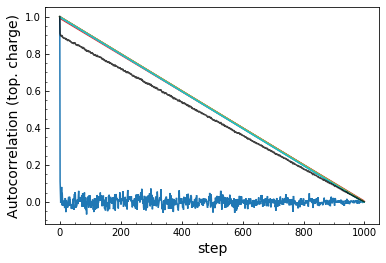

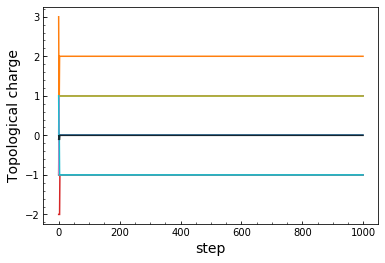

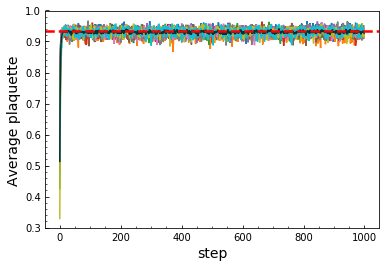

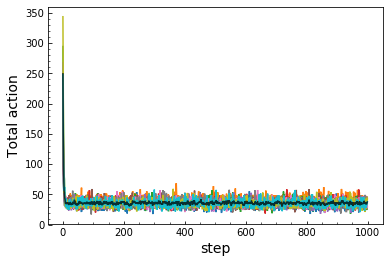

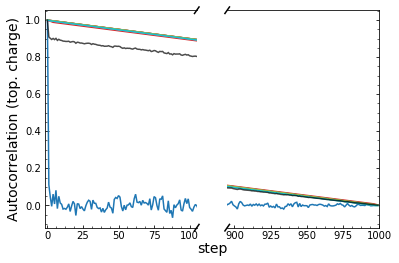

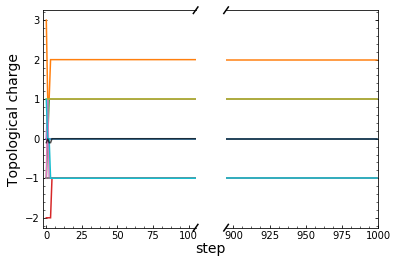

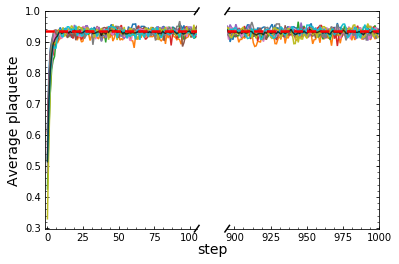

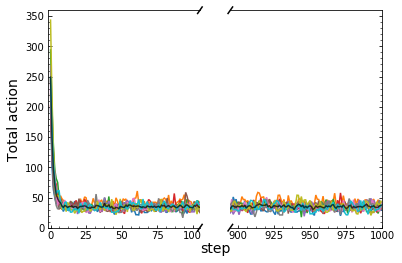

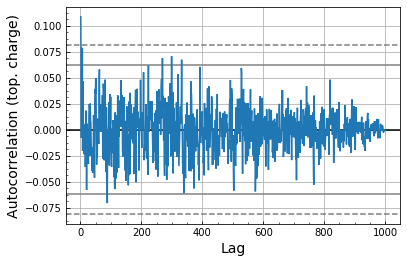

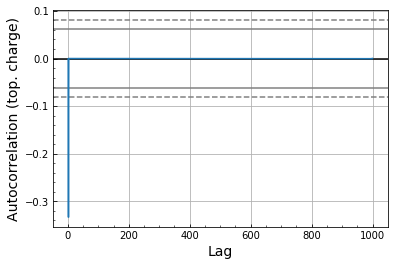

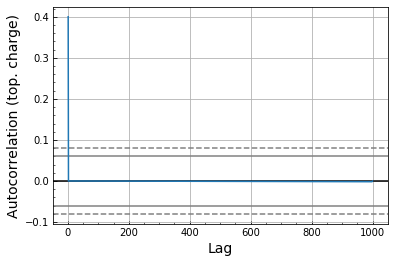

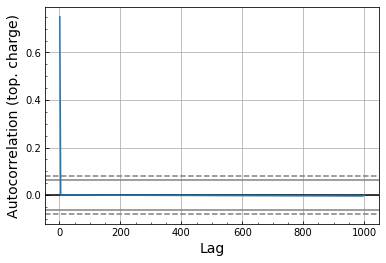

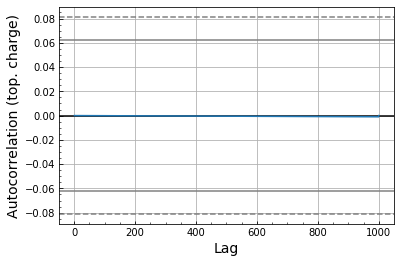

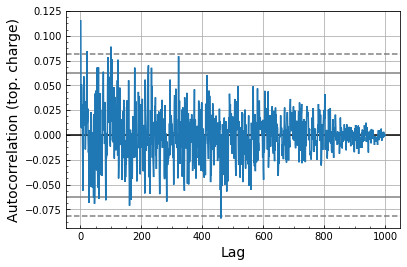

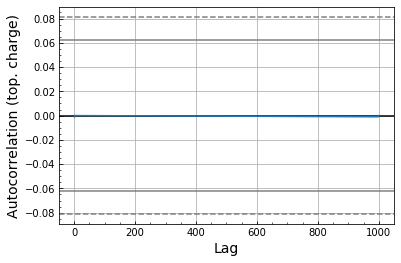

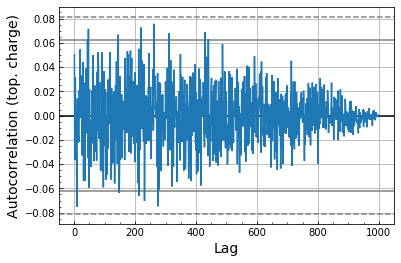

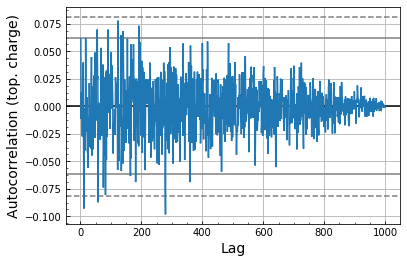

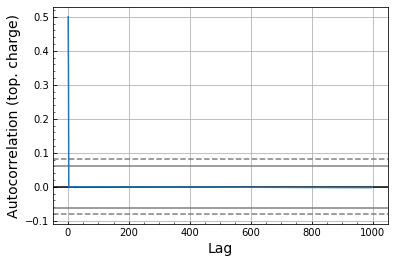

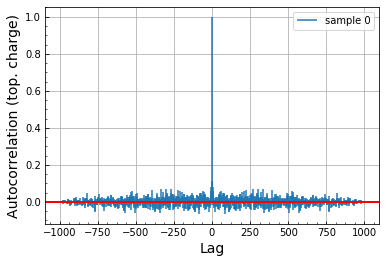

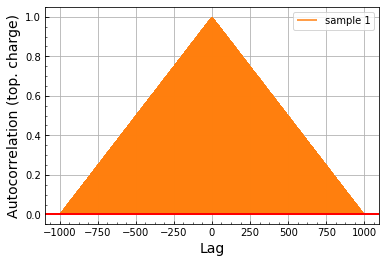

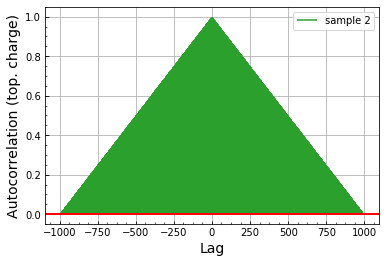

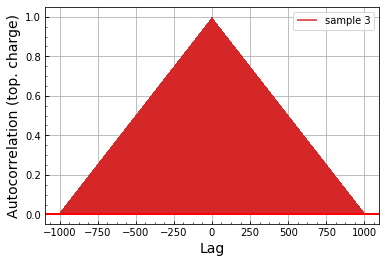

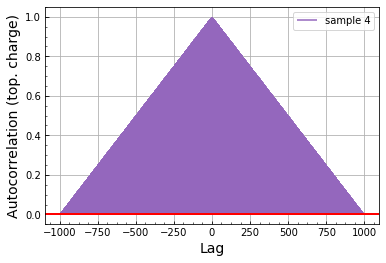

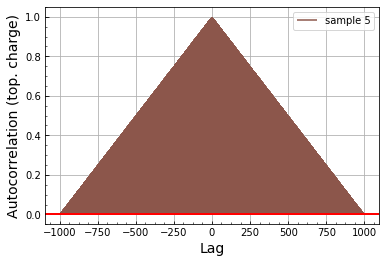

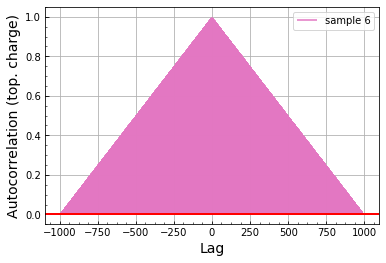

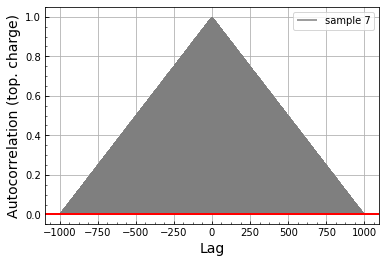

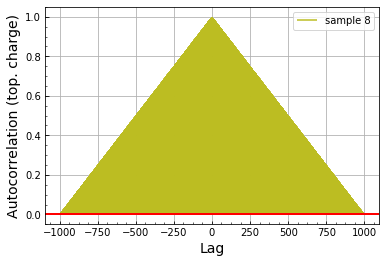

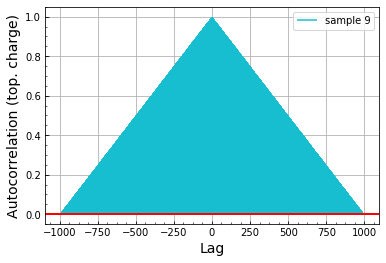

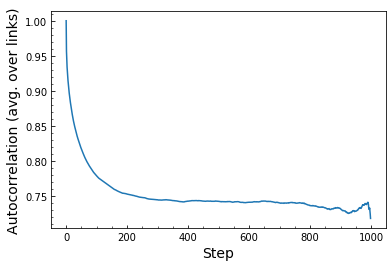

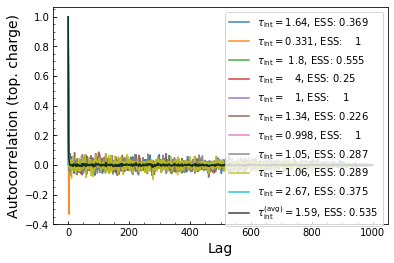

In [10]:
log_dir = (
    '../../gauge_logs_graph/gauge_logs_by_size/HMC/eight_by_eight//'
)

calc_observables_generate_plots(log_dir)

In [7]:
root_dir = ('../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/')
log_dirs = [
    root_dir + d for d in os.listdir(root_dir) 
    if os.path.isdir(os.path.join(root_dir, d))
]
log_dirs

['../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_52',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_41',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_61',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_28',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_45']

Loading samples from: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_52/run_info/samples_history.pkl.
step: 0 time/step: 0.3443 avg action:  1841  avg plaquette: 0.1012 top charges: 


[0, -1, 7, 3]


step: 1 time/step: 0.3184 avg action:  1839  avg plaquette: 0.1022 top charges: 


[0, -1, 6, 3]


step: 2 time/step: 0.2931 avg action:  1836  avg plaquette: 0.1035 top charges: 


[1, -1, 7, 2]


step: 3 time/step: 0.4451 avg action:  1833  avg plaquette: 0.1047 top charges: 


[1, -1, 7, 5]


step: 4 time/step: 0.2902 avg action:  1831  avg plaquette: 0.1061 top charges: 


[1, -2, 7, 5]


step: 5 time/step: 0.3017 avg action:  1828  avg plaquette: 0.1073 top charges: 


[1, -3, 7, 6]


step: 6 time/step: 0.2606 avg action:  1827  avg plaquette: 0.108  top charges: 


[0, -3, 7, 5]


step: 7 time/step: 0.4225 avg action:  1823  avg plaquette: 0.1097 top charges: 


[0, -2, 7, 6]


step: 8 time/step: 0.3171 avg action:  1821  avg plaquette: 0.111  top charges: 


[-1, 

step: 81 time/step: 0.3943 avg action:  1665  avg plaquette: 0.187  top charges: 


[1, -3, 7, 5]


step: 82 time/step: 0.4237 avg action:  1663  avg plaquette: 0.1878 top charges: 


[-1, -3, 8, 3]


step: 83 time/step: 0.3134 avg action:  1661  avg plaquette: 0.1889 top charges: 


[-1, -4, 7, 3]


step: 84 time/step: 0.3225 avg action:  1661  avg plaquette: 0.1892 top charges: 


[-1, -3, 8, 2]


step: 85 time/step: 0.6951 avg action:  1659  avg plaquette: 0.1897 top charges: 


[0, -1, 7, 2]


step: 86 time/step: 0.3388 avg action:  1657  avg plaquette: 0.1911 top charges: 


[0, -2, 7, 3]


step: 87 time/step: 0.3266 avg action:  1657  avg plaquette: 0.1911 top charges: 


[0, -2, 8, 3]


step: 88 time/step: 0.342  avg action:  1652  avg plaquette: 0.1934 top charges: 


[0, -1, 8, 1]


step: 89 time/step: 0.6216 avg action:  1650  avg plaquette: 0.1944 top charges: 


[0, 0, 8, 1]


step: 90 time/step: 0.3111 avg action:  1650  avg plaquette: 0.1945 top charges: 


[0, -1, 6, 2]


step: 162 time/step: 0.2772 avg action:  1496  avg plaquette: 0.2694 top charges: 


[0, -2, 8, 6]


step: 163 time/step: 0.2705 avg action:  1494  avg plaquette: 0.2704 top charges: 


[0, -1, 6, 4]


step: 164 time/step: 0.3594 avg action:  1492  avg plaquette: 0.2713 top charges: 


[0, -1, 6, 5]


step: 165 time/step: 0.406  avg action:  1491  avg plaquette: 0.2718 top charges: 


[0, -1, 6, 5]


step: 166 time/step: 0.3173 avg action:  1491  avg plaquette: 0.2719 top charges: 


[-1, -1, 6, 5]


step: 167 time/step: 0.2714 avg action:  1489  avg plaquette: 0.273  top charges: 


[0, 0, 7, 3]


step: 168 time/step: 0.3019 avg action:  1487  avg plaquette: 0.274  top charges: 


[1, -1, 6, 5]


step: 169 time/step: 0.3015 avg action:  1485  avg plaquette: 0.275  top charges: 


[0, -1, 6, 3]


step: 170 time/step: 0.3049 avg action:  1484  avg plaquette: 0.2752 top charges: 


[1, -1, 5, 5]


step: 171 time/step: 0.2955 avg action:  1482  avg plaquette: 0.2763 top charges: 


[0, -1

step: 243 time/step: 0.2595 avg action:  1357  avg plaquette: 0.3376 top charges: 


[-1, -2, 5, 2]


step: 244 time/step: 0.2825 avg action:  1355  avg plaquette: 0.3385 top charges: 


[0, -2, 5, 3]


step: 245 time/step: 0.4293 avg action:  1353  avg plaquette: 0.3392 top charges: 


[0, -1, 4, 3]


step: 246 time/step: 0.3402 avg action:  1353  avg plaquette: 0.3394 top charges: 


[0, 0, 4, 3]


step: 247 time/step: 0.321  avg action:  1351  avg plaquette: 0.3402 top charges: 


[-2, 0, 5, 2]


step: 248 time/step: 0.3038 avg action:  1348  avg plaquette: 0.3417 top charges: 


[0, 0, 6, 2]


step: 249 time/step: 0.3127 avg action:  1347  avg plaquette: 0.3424 top charges: 


[-1, 0, 5, 2]


step: 250 time/step: 0.3168 avg action:  1345  avg plaquette: 0.3435 top charges: 


[0, 0, 6, 3]


step: 251 time/step: 0.2826 avg action:  1345  avg plaquette: 0.3434 top charges: 


[2, -1, 6, 3]


step: 252 time/step: 0.3682 avg action:  1343  avg plaquette: 0.3441 top charges: 


[1, -2, 

step: 325 time/step: 0.3188 avg action:  1222  avg plaquette: 0.4034 top charges: 


[1, -2, 6, 2]


step: 326 time/step: 0.3534 avg action:  1220  avg plaquette: 0.4041 top charges: 


[3, -3, 5, 2]


step: 327 time/step: 0.4412 avg action:  1220  avg plaquette: 0.4044 top charges: 


[1, -1, 6, 2]


step: 328 time/step: 0.3114 avg action:  1220  avg plaquette: 0.4043 top charges: 


[2, -2, 6, 3]


step: 329 time/step: 0.2625 avg action:  1219  avg plaquette: 0.4046 top charges: 


[1, -3, 5, 3]


step: 330 time/step: 0.2957 avg action:  1217  avg plaquette: 0.4058 top charges: 


[1, -3, 6, 3]


step: 331 time/step: 0.296  avg action:  1215  avg plaquette: 0.4069 top charges: 


[1, -2, 5, 3]


step: 332 time/step: 0.2949 avg action:  1213  avg plaquette: 0.4078 top charges: 


[2, -3, 5, 2]


step: 333 time/step: 0.2891 avg action:  1212  avg plaquette: 0.4081 top charges: 


[2, -4, 6, 2]


step: 334 time/step: 0.3017 avg action:  1211  avg plaquette: 0.4085 top charges: 


[2, -3

step: 407 time/step: 0.3744 avg action:  1118  avg plaquette: 0.4539 top charges: 


[0, -4, 7, 3]


step: 408 time/step: 0.3061 avg action:  1116  avg plaquette: 0.4551 top charges: 


[1, -4, 6, 3]


step: 409 time/step: 0.2906 avg action:  1114  avg plaquette: 0.456  top charges: 


[0, -5, 7, 3]


step: 410 time/step: 0.3402 avg action:  1114  avg plaquette: 0.4562 top charges: 


[0, -5, 7, 2]


step: 411 time/step: 0.4257 avg action:  1113  avg plaquette: 0.4565 top charges: 


[1, -4, 6, 2]


step: 412 time/step: 0.3159 avg action:  1113  avg plaquette: 0.4568 top charges: 


[1, -4, 6, 0]


step: 413 time/step: 0.3068 avg action:  1111  avg plaquette: 0.4573 top charges: 


[2, -4, 7, 0]


step: 414 time/step: 0.3068 avg action:  1109  avg plaquette: 0.4585 top charges: 


[1, -4, 6, 0]


step: 415 time/step: 0.3032 avg action:  1108  avg plaquette: 0.459  top charges: 


[0, -4, 6, 1]


step: 416 time/step: 0.2746 avg action:  1106  avg plaquette: 0.4597 top charges: 


[0, -3

step: 489 time/step: 0.3588 avg action:  1016  avg plaquette: 0.5037 top charges: 


[0, -3, 4, 0]


step: 490 time/step: 0.4394 avg action:  1017  avg plaquette: 0.5034 top charges: 


[-1, -2, 4, 0]


step: 491 time/step: 0.3159 avg action:  1016  avg plaquette: 0.5038 top charges: 


[0, -3, 3, 0]


step: 492 time/step: 0.4605 avg action:  1016  avg plaquette: 0.5037 top charges: 


[0, -2, 4, 0]


step: 493 time/step: 0.3946 avg action:  1015  avg plaquette: 0.5045 top charges: 


[0, -2, 3, 0]


step: 494 time/step: 0.3997 avg action:  1013  avg plaquette: 0.5052 top charges: 


[0, -1, 4, 0]


step: 495 time/step: 0.2888 avg action:  1014  avg plaquette: 0.505  top charges: 


[0, -2, 3, 0]


step: 496 time/step: 0.5068 avg action:  1011  avg plaquette: 0.5064 top charges: 


[0, -1, 4, 0]


step: 497 time/step: 0.5274 avg action:  1011  avg plaquette: 0.5066 top charges: 


[0, -1, 4, 0]


step: 498 time/step: 0.3577 avg action:  1010  avg plaquette: 0.5071 top charges: 


[0, -

step: 38 time/step: 0.4471 avg action: 145.4  avg plaquette: 0.929  top charges: 


[-1, 0, 4, 1]


step: 39 time/step: 0.4291 avg action: 133.9  avg plaquette: 0.9346 top charges: 


[0, -1, 5, 1]


step: 40 time/step: 0.2945 avg action:  135   avg plaquette: 0.9341 top charges: 


[-1, -1, 4, 1]


step: 41 time/step: 0.4297 avg action: 145.3  avg plaquette: 0.9291 top charges: 


[-1, -1, 4, 1]


step: 42 time/step: 0.3212 avg action: 147.1  avg plaquette: 0.9282 top charges: 


[-1, 0, 5, 1]


step: 43 time/step: 0.4759 avg action:  138   avg plaquette: 0.9326 top charges: 


[0, -1, 5, 1]


step: 44 time/step: 0.6041 avg action: 130.8  avg plaquette: 0.9361 top charges: 


[-1, -1, 4, 2]


step: 45 time/step: 0.2958 avg action: 142.5  avg plaquette: 0.9304 top charges: 


[-1, -1, 4, 1]


step: 46 time/step: 0.2801 avg action: 139.2  avg plaquette: 0.9321 top charges: 


[-1, 0, 4, 1]


step: 47 time/step: 0.4851 avg action: 134.5  avg plaquette: 0.9343 top charges: 


[-1, 0, 4, 2

step: 120 time/step: 0.3376 avg action: 150.2  avg plaquette: 0.9267 top charges: 


[0, 0, 4, 1]


step: 121 time/step: 0.316  avg action: 159.6  avg plaquette: 0.9221 top charges: 


[0, 0, 4, 1]


step: 122 time/step: 0.3981 avg action: 152.8  avg plaquette: 0.9254 top charges: 


[0, -1, 4, 2]


step: 123 time/step: 0.2964 avg action: 147.1  avg plaquette: 0.9282 top charges: 


[-1, -1, 4, 2]


step: 124 time/step: 0.3396 avg action: 148.5  avg plaquette: 0.9275 top charges: 


[-1, -1, 5, 2]


step: 125 time/step: 0.3069 avg action: 152.4  avg plaquette: 0.9256 top charges: 


[0, 0, 5, 2]


step: 126 time/step: 0.3594 avg action: 147.2  avg plaquette: 0.9281 top charges: 


[-1, 0, 4, 2]


step: 127 time/step: 0.2925 avg action: 144.9  avg plaquette: 0.9293 top charges: 


[0, 0, 4, 2]


step: 128 time/step: 0.2743 avg action: 146.4  avg plaquette: 0.9285 top charges: 


[-1, -1, 4, 2]


step: 129 time/step: 0.3696 avg action: 147.9  avg plaquette: 0.9278 top charges: 


[-1, 0,

step: 202 time/step: 0.3363 avg action: 141.4  avg plaquette: 0.9309 top charges: 


[-1, 0, 4, 1]


step: 203 time/step: 0.3089 avg action: 139.6  avg plaquette: 0.9318 top charges: 


[0, 0, 5, 1]


step: 204 time/step: 0.2776 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[-1, -1, 5, 1]


step: 205 time/step: 0.2994 avg action:  140   avg plaquette: 0.9316 top charges: 


[0, 0, 4, 1]


step: 206 time/step: 0.3569 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[0, -1, 4, 1]


step: 207 time/step: 0.5577 avg action: 138.4  avg plaquette: 0.9324 top charges: 


[0, -1, 4, 1]


step: 208 time/step: 0.3517 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[0, -1, 5, 1]


step: 209 time/step: 0.3999 avg action: 138.3  avg plaquette: 0.9325 top charges: 


[-1, 0, 5, 1]


step: 210 time/step: 0.3576 avg action: 137.6  avg plaquette: 0.9328 top charges: 


[0, -1, 4, 1]


step: 211 time/step: 0.3989 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[0, -1,

step: 284 time/step: 0.4012 avg action:  125   avg plaquette: 0.939  top charges: 


[0, 0, 5, 1]


step: 285 time/step: 0.2797 avg action: 129.8  avg plaquette: 0.9366 top charges: 


[-1, 0, 5, 1]


step: 286 time/step: 0.3412 avg action: 136.2  avg plaquette: 0.9335 top charges: 


[0, 0, 4, 2]


step: 287 time/step: 0.7187 avg action: 134.8  avg plaquette: 0.9342 top charges: 


[-1, -1, 5, 1]


step: 288 time/step: 0.7401 avg action: 133.3  avg plaquette: 0.9349 top charges: 


[-1, -1, 5, 2]


step: 289 time/step: 1.162  avg action: 141.4  avg plaquette: 0.931  top charges: 


[0, 0, 5, 2]


step: 290 time/step: 1.004  avg action: 131.3  avg plaquette: 0.9359 top charges: 


[-1, 0, 4, 1]


step: 291 time/step: 0.8844 avg action: 129.6  avg plaquette: 0.9367 top charges: 


[-1, -1, 4, 2]


step: 292 time/step: 1.378  avg action: 130.5  avg plaquette: 0.9363 top charges: 


[-1, -1, 5, 1]


step: 293 time/step: 0.7682 avg action: 141.5  avg plaquette: 0.9309 top charges: 


[0, -

step: 366 time/step: 0.3099 avg action: 135.6  avg plaquette: 0.9338 top charges: 


[-1, -1, 5, 1]


step: 367 time/step: 0.4043 avg action: 130.9  avg plaquette: 0.9361 top charges: 


[0, 0, 4, 2]


step: 368 time/step: 0.3476 avg action: 129.8  avg plaquette: 0.9366 top charges: 


[0, -1, 5, 2]


step: 369 time/step: 0.2681 avg action: 138.3  avg plaquette: 0.9325 top charges: 


[-1, 0, 5, 1]


step: 370 time/step: 0.3577 avg action: 136.1  avg plaquette: 0.9335 top charges: 


[0, -1, 4, 1]


step: 371 time/step: 0.258  avg action:  135   avg plaquette: 0.9341 top charges: 


[-1, 0, 4, 1]


step: 372 time/step: 0.2378 avg action: 133.5  avg plaquette: 0.9348 top charges: 


[-1, 0, 4, 2]


step: 373 time/step: 0.287  avg action: 136.5  avg plaquette: 0.9334 top charges: 


[0, 0, 4, 2]


step: 374 time/step: 0.3309 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[-1, -1, 4, 2]


step: 375 time/step: 0.3776 avg action: 137.4  avg plaquette: 0.9329 top charges: 


[0, -1

step: 448 time/step: 0.3978 avg action: 147.5  avg plaquette: 0.928  top charges: 


[0, 0, 5, 2]


step: 449 time/step: 0.2824 avg action: 151.5  avg plaquette: 0.926  top charges: 


[0, 0, 4, 2]


step: 450 time/step: 0.2569 avg action: 145.2  avg plaquette: 0.9291 top charges: 


[-1, 0, 4, 1]


step: 451 time/step: 0.2487 avg action: 139.4  avg plaquette: 0.9319 top charges: 


[-1, 0, 5, 2]


step: 452 time/step: 0.2547 avg action: 147.2  avg plaquette: 0.9281 top charges: 


[-1, 0, 4, 1]


step: 453 time/step: 0.3021 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[-1, -1, 4, 1]


step: 454 time/step: 0.5174 avg action: 142.7  avg plaquette: 0.9303 top charges: 


[-1, -1, 4, 2]


step: 455 time/step: 0.401  avg action: 137.8  avg plaquette: 0.9327 top charges: 


[0, 0, 4, 2]


step: 456 time/step: 0.2676 avg action: 138.8  avg plaquette: 0.9322 top charges: 


[-1, -1, 4, 1]


step: 457 time/step: 0.5039 avg action: 127.3  avg plaquette: 0.9379 top charges: 


[0, 0,

/Users/saforem2/miniconda3/envs/intelpy3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/topological_charge_autocorr_fn_broken_xaxis.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/average_action_vs_step_broken_xaxis.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_0.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_1.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_2.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_4

step: 61 time/step: 0.2555 avg action: 134.9  avg plaquette: 0.9342 top charges: 


[-1, -3, 1, 0]


step: 62 time/step: 0.2687 avg action: 135.3  avg plaquette: 0.934  top charges: 


[-1, -3, 1, 0]


step: 63 time/step: 0.2938 avg action: 143.6  avg plaquette: 0.9299 top charges: 


[-1, -4, 0, 0]


step: 64 time/step: 0.3882 avg action: 136.2  avg plaquette: 0.9335 top charges: 


[-1, -3, 0, 0]


step: 65 time/step: 0.5482 avg action: 137.2  avg plaquette: 0.933  top charges: 


[-1, -3, 0, 0]


step: 66 time/step: 0.4696 avg action:  145   avg plaquette: 0.9292 top charges: 


[0, -4, 0, 0]


step: 67 time/step: 0.2975 avg action: 144.5  avg plaquette: 0.9294 top charges: 


[0, -3, 1, 0]


step: 68 time/step: 0.2879 avg action:  139   avg plaquette: 0.9321 top charges: 


[0, -3, 0, 0]


step: 69 time/step: 0.2528 avg action: 139.2  avg plaquette: 0.932  top charges: 


[0, -4, 0, 0]


step: 70 time/step: 0.5152 avg action: 137.5  avg plaquette: 0.9328 top charges: 


[-1, -4, 1,

step: 143 time/step: 0.328  avg action: 136.8  avg plaquette: 0.9332 top charges: 


[-1, -3, 1, 0]


step: 144 time/step: 0.3194 avg action: 142.9  avg plaquette: 0.9302 top charges: 


[-1, -4, 1, 0]


step: 145 time/step: 0.3254 avg action: 139.1  avg plaquette: 0.9321 top charges: 


[0, -4, 0, 0]


step: 146 time/step: 0.3194 avg action: 130.9  avg plaquette: 0.9361 top charges: 


[0, -4, 0, 0]


step: 147 time/step: 0.3168 avg action: 130.1  avg plaquette: 0.9365 top charges: 


[0, -4, 0, 0]


step: 148 time/step: 0.447  avg action: 126.7  avg plaquette: 0.9382 top charges: 


[0, -3, 0, 0]


step: 149 time/step: 0.5573 avg action: 130.3  avg plaquette: 0.9364 top charges: 


[-1, -4, 1, 0]


step: 150 time/step: 0.4508 avg action: 137.7  avg plaquette: 0.9327 top charges: 


[0, -3, 0, 0]


step: 151 time/step: 0.3032 avg action: 136.4  avg plaquette: 0.9334 top charges: 


[-1, -3, 0, 0]


step: 152 time/step: 0.6713 avg action: 141.3  avg plaquette: 0.931  top charges: 


[0

step: 224 time/step: 0.2594 avg action: 151.8  avg plaquette: 0.9259 top charges: 


[-1, -4, 1, 0]


step: 225 time/step: 0.2513 avg action: 144.3  avg plaquette: 0.9295 top charges: 


[0, -3, 0, 0]


step: 226 time/step: 0.2556 avg action: 144.2  avg plaquette: 0.9296 top charges: 


[-1, -3, 0, 0]


step: 227 time/step: 0.3176 avg action: 141.6  avg plaquette: 0.9309 top charges: 


[0, -3, 0, 0]


step: 228 time/step: 0.3367 avg action: 143.8  avg plaquette: 0.9298 top charges: 


[0, -4, 1, 0]


step: 229 time/step: 0.2965 avg action: 140.1  avg plaquette: 0.9316 top charges: 


[-1, -4, 1, 0]


step: 230 time/step: 0.3164 avg action: 151.6  avg plaquette: 0.926  top charges: 


[-1, -4, 0, 0]


step: 231 time/step: 0.3333 avg action: 150.7  avg plaquette: 0.9264 top charges: 


[0, -3, 0, 0]


step: 232 time/step: 0.3244 avg action: 147.4  avg plaquette: 0.928  top charges: 


[0, -4, 1, 0]


step: 233 time/step: 0.4917 avg action: 149.2  avg plaquette: 0.9272 top charges: 


[0

step: 305 time/step: 0.7857 avg action: 134.6  avg plaquette: 0.9343 top charges: 


[-1, -4, 1, 0]


step: 306 time/step: 0.6712 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[0, -3, 1, 0]


step: 307 time/step: 0.5033 avg action: 139.5  avg plaquette: 0.9319 top charges: 


[-1, -3, 0, 0]


step: 308 time/step: 0.6697 avg action: 137.8  avg plaquette: 0.9327 top charges: 


[-1, -4, 1, 0]


step: 309 time/step: 0.6585 avg action: 132.4  avg plaquette: 0.9353 top charges: 


[0, -3, 1, 0]


step: 310 time/step: 0.5457 avg action: 130.7  avg plaquette: 0.9362 top charges: 


[-1, -3, 1, 0]


step: 311 time/step: 0.8588 avg action: 128.8  avg plaquette: 0.9371 top charges: 


[-1, -3, 1, 0]


step: 312 time/step: 0.8882 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[0, -3, 1, 0]


step: 313 time/step: 0.4532 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[-1, -4, 0, 0]


step: 314 time/step: 0.8246 avg action: 142.4  avg plaquette: 0.9305 top charges: 




step: 386 time/step: 0.395  avg action: 130.1  avg plaquette: 0.9365 top charges: 


[-1, -4, 1, 0]


step: 387 time/step: 0.3316 avg action: 132.5  avg plaquette: 0.9353 top charges: 


[-1, -3, 1, 0]


step: 388 time/step: 0.3416 avg action: 143.4  avg plaquette:  0.93  top charges: 


[0, -4, 0, 0]


step: 389 time/step: 0.2838 avg action: 148.4  avg plaquette: 0.9275 top charges: 


[-1, -4, 0, 0]


step: 390 time/step: 0.3015 avg action: 148.6  avg plaquette: 0.9274 top charges: 


[0, -4, 0, 0]


step: 391 time/step: 0.3987 avg action: 148.8  avg plaquette: 0.9273 top charges: 


[-1, -3, 1, 0]


step: 392 time/step: 0.3294 avg action: 149.8  avg plaquette: 0.9269 top charges: 


[-1, -3, 1, 0]


step: 393 time/step: 0.3323 avg action:  151   avg plaquette: 0.9263 top charges: 


[0, -4, 1, 0]


step: 394 time/step: 0.3384 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[0, -3, 0, 0]


step: 395 time/step: 0.2858 avg action: 135.8  avg plaquette: 0.9337 top charges: 


[

step: 467 time/step: 0.3162 avg action: 128.4  avg plaquette: 0.9373 top charges: 


[0, -3, 0, 0]


step: 468 time/step: 0.3653 avg action: 134.9  avg plaquette: 0.9341 top charges: 


[0, -4, 1, 0]


step: 469 time/step: 0.4315 avg action: 133.4  avg plaquette: 0.9349 top charges: 


[0, -4, 0, 0]


step: 470 time/step: 0.3952 avg action: 139.6  avg plaquette: 0.9318 top charges: 


[0, -3, 0, 0]


step: 471 time/step: 0.2928 avg action: 134.6  avg plaquette: 0.9343 top charges: 


[-1, -4, 1, 0]


step: 472 time/step: 0.3084 avg action:  136   avg plaquette: 0.9336 top charges: 


[-1, -4, 0, 0]


step: 473 time/step: 0.3162 avg action: 137.7  avg plaquette: 0.9328 top charges: 


[0, -3, 1, 0]


step: 474 time/step: 0.317  avg action: 141.9  avg plaquette: 0.9307 top charges: 


[0, -3, 0, 0]


step: 475 time/step: 0.2951 avg action: 126.7  avg plaquette: 0.9381 top charges: 


[0, -4, 1, 0]


step: 476 time/step: 0.3895 avg action:  138   avg plaquette: 0.9326 top charges: 


[0, 

step: 27 time/step: 0.2052 avg action: 181.7  avg plaquette: 0.9113 top charges: 


[3, 2]


step: 28 time/step: 0.1386 avg action: 184.7  avg plaquette: 0.9098 top charges: 


[3, 1]


step: 29 time/step: 0.1531 avg action: 180.1  avg plaquette: 0.9121 top charges: 


[3, 1]


step: 30 time/step: 0.232  avg action: 173.1  avg plaquette: 0.9155 top charges: 


[3, 2]


step: 31 time/step: 0.1353 avg action: 176.7  avg plaquette: 0.9137 top charges: 


[2, 2]


step: 32 time/step: 0.157  avg action: 173.7  avg plaquette: 0.9152 top charges: 


[2, 1]


step: 33 time/step: 0.1439 avg action: 175.6  avg plaquette: 0.9143 top charges: 


[2, 1]


step: 34 time/step: 0.144  avg action: 165.4  avg plaquette: 0.9193 top charges: 


[2, 1]


step: 35 time/step: 0.1317 avg action:  164   avg plaquette: 0.9199 top charges: 


[3, 1]


step: 36 time/step: 0.1464 avg action:  164   avg plaquette: 0.9199 top charges: 


[3, 1]


step: 37 time/step: 0.1281 avg action: 162.6  avg plaquette: 0.9206 to

step: 116 time/step: 0.1523 avg action: 154.5  avg plaquette: 0.9246 top charges: 


[2, 2]


step: 117 time/step: 0.2261 avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 2]


step: 118 time/step: 0.256  avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 2]


step: 119 time/step: 0.2346 avg action: 151.1  avg plaquette: 0.9262 top charges: 


[3, 2]


step: 120 time/step: 0.2397 avg action: 160.9  avg plaquette: 0.9214 top charges: 


[3, 2]


step: 121 time/step: 0.2659 avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 2]


step: 122 time/step: 0.2133 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 123 time/step: 0.2754 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 124 time/step: 0.3323 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 125 time/step: 0.4044 avg action: 162.2  avg plaquette: 0.9208 top charges: 


[2, 2]


step: 126 time/step: 0.2435 avg action: 156.4  avg plaquette

step: 204 time/step: 0.2106 avg action: 146.8  avg plaquette: 0.9283 top charges: 


[2, 1]


step: 205 time/step: 0.2217 avg action: 152.8  avg plaquette: 0.9254 top charges: 


[2, 2]


step: 206 time/step: 0.4596 avg action:  154   avg plaquette: 0.9248 top charges: 


[2, 2]


step: 207 time/step: 0.2039 avg action: 151.3  avg plaquette: 0.9261 top charges: 


[2, 1]


step: 208 time/step: 0.1898 avg action: 152.3  avg plaquette: 0.9256 top charges: 


[2, 1]


step: 209 time/step: 0.2214 avg action: 160.5  avg plaquette: 0.9216 top charges: 


[3, 1]


step: 210 time/step: 0.1785 avg action: 160.5  avg plaquette: 0.9216 top charges: 


[3, 1]


step: 211 time/step: 0.2098 avg action: 167.3  avg plaquette: 0.9183 top charges: 


[2, 1]


step: 212 time/step: 0.2228 avg action: 162.5  avg plaquette: 0.9207 top charges: 


[2, 2]


step: 213 time/step: 0.2266 avg action: 158.9  avg plaquette: 0.9224 top charges: 


[3, 1]


step: 214 time/step: 0.261  avg action: 152.2  avg plaquette

step: 292 time/step: 0.1829 avg action: 150.8  avg plaquette: 0.9264 top charges: 


[3, 1]


step: 293 time/step: 0.5042 avg action: 150.8  avg plaquette: 0.9264 top charges: 


[3, 1]


step: 294 time/step: 1.118  avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 1]


step: 295 time/step: 1.134  avg action: 152.8  avg plaquette: 0.9254 top charges: 


[2, 1]


step: 296 time/step: 0.5347 avg action:  158   avg plaquette: 0.9228 top charges: 


[3, 1]


step: 297 time/step: 1.028  avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 1]


step: 298 time/step: 0.5156 avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 1]


step: 299 time/step: 0.4073 avg action: 161.4  avg plaquette: 0.9212 top charges: 


[2, 1]


step: 300 time/step: 0.6082 avg action: 155.4  avg plaquette: 0.9241 top charges: 


[3, 1]


step: 301 time/step: 0.4515 avg action: 155.4  avg plaquette: 0.9241 top charges: 


[3, 1]


step: 302 time/step: 0.2672 avg action: 155.4  avg plaquette

step: 380 time/step: 0.1814 avg action: 164.3  avg plaquette: 0.9198 top charges: 


[2, 2]


step: 381 time/step: 0.1834 avg action: 166.4  avg plaquette: 0.9187 top charges: 


[2, 2]


step: 382 time/step: 0.2363 avg action: 160.3  avg plaquette: 0.9217 top charges: 


[2, 1]


step: 383 time/step: 0.2304 avg action: 176.6  avg plaquette: 0.9138 top charges: 


[2, 2]


step: 384 time/step: 0.2705 avg action: 176.6  avg plaquette: 0.9138 top charges: 


[2, 2]


step: 385 time/step: 0.2143 avg action: 169.1  avg plaquette: 0.9174 top charges: 


[2, 2]


step: 386 time/step: 0.5014 avg action: 169.2  avg plaquette: 0.9174 top charges: 


[2, 1]


step: 387 time/step: 0.3317 avg action: 166.8  avg plaquette: 0.9186 top charges: 


[3, 1]


step: 388 time/step: 0.3207 avg action: 169.6  avg plaquette: 0.9172 top charges: 


[2, 1]


step: 389 time/step: 0.295  avg action: 167.6  avg plaquette: 0.9182 top charges: 


[2, 1]


step: 390 time/step: 0.2536 avg action: 167.6  avg plaquette

step: 468 time/step: 0.2136 avg action: 162.8  avg plaquette: 0.9205 top charges: 


[2, 2]


step: 469 time/step: 0.1969 avg action: 162.8  avg plaquette: 0.9205 top charges: 


[2, 2]


step: 470 time/step: 0.1948 avg action: 166.9  avg plaquette: 0.9185 top charges: 


[3, 2]


step: 471 time/step: 0.216  avg action: 166.9  avg plaquette: 0.9185 top charges: 


[3, 2]


step: 472 time/step: 0.1832 avg action: 159.4  avg plaquette: 0.9221 top charges: 


[3, 2]


step: 473 time/step: 0.1763 avg action: 159.4  avg plaquette: 0.9221 top charges: 


[3, 2]


step: 474 time/step: 0.1933 avg action: 158.1  avg plaquette: 0.9228 top charges: 


[3, 2]


step: 475 time/step: 0.1728 avg action: 158.1  avg plaquette: 0.9228 top charges: 


[3, 2]


step: 476 time/step: 0.2066 avg action: 160.8  avg plaquette: 0.9215 top charges: 


[3, 2]


step: 477 time/step: 0.1895 avg action: 164.5  avg plaquette: 0.9197 top charges: 


[3, 1]


step: 478 time/step: 0.2285 avg action: 157.4  avg plaquette

step: 36 time/step: 0.2811 avg action: 192.3  avg plaquette: 0.9061 top charges: 


[-1, 3]


step: 37 time/step: 0.2171 avg action: 193.6  avg plaquette: 0.9055 top charges: 


[-1, 4]


step: 38 time/step: 0.2515 avg action:  192   avg plaquette: 0.9062 top charges: 


[-1, 4]


step: 39 time/step: 0.1991 avg action:  194   avg plaquette: 0.9053 top charges: 


[-1, 4]


step: 40 time/step: 0.2091 avg action: 196.3  avg plaquette: 0.9042 top charges: 


[-1, 4]


step: 41 time/step: 0.2235 avg action: 193.5  avg plaquette: 0.9055 top charges: 


[0, 3]


step: 42 time/step: 0.2586 avg action: 197.5  avg plaquette: 0.9036 top charges: 


[0, 4]


step: 43 time/step: 0.4026 avg action: 192.8  avg plaquette: 0.9059 top charges: 


[0, 4]


step: 44 time/step: 0.3688 avg action: 188.7  avg plaquette: 0.9079 top charges: 


[0, 3]


step: 45 time/step: 0.3641 avg action: 184.4  avg plaquette:  0.91  top charges: 


[-1, 3]


step: 46 time/step: 0.3154 avg action: 180.4  avg plaquette: 0.9

step: 125 time/step: 0.3985 avg action: 159.6  avg plaquette: 0.9221 top charges: 


[0, 3]


step: 126 time/step: 0.2694 avg action: 162.1  avg plaquette: 0.9209 top charges: 


[0, 3]


step: 127 time/step: 0.1786 avg action: 145.1  avg plaquette: 0.9292 top charges: 


[0, 4]


step: 128 time/step: 0.1724 avg action: 145.8  avg plaquette: 0.9288 top charges: 


[-1, 4]


step: 129 time/step: 0.3296 avg action: 146.6  avg plaquette: 0.9284 top charges: 


[0, 4]


step: 130 time/step: 0.1764 avg action: 145.9  avg plaquette: 0.9288 top charges: 


[0, 4]


step: 131 time/step: 0.4053 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[0, 4]


step: 132 time/step: 0.5995 avg action: 149.9  avg plaquette: 0.9268 top charges: 


[0, 4]


step: 133 time/step: 0.2721 avg action: 149.2  avg plaquette: 0.9271 top charges: 


[-1, 3]


step: 134 time/step: 0.163  avg action:  149   avg plaquette: 0.9272 top charges: 


[0, 4]


step: 135 time/step: 0.1522 avg action: 147.5  avg plaquet

step: 213 time/step: 0.1446 avg action: 166.2  avg plaquette: 0.9189 top charges: 


[0, 4]


step: 214 time/step: 0.1493 avg action: 160.2  avg plaquette: 0.9218 top charges: 


[0, 4]


step: 215 time/step: 0.1294 avg action: 152.1  avg plaquette: 0.9257 top charges: 


[0, 4]


step: 216 time/step: 0.1909 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[0, 3]


step: 217 time/step: 0.1994 avg action: 138.1  avg plaquette: 0.9326 top charges: 


[-1, 4]


step: 218 time/step: 0.1906 avg action: 147.7  avg plaquette: 0.9279 top charges: 


[-1, 4]


step: 219 time/step: 0.2374 avg action: 143.7  avg plaquette: 0.9298 top charges: 


[0, 3]


step: 220 time/step: 0.3735 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 4]


step: 221 time/step: 0.3925 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 4]


step: 222 time/step: 0.1936 avg action: 145.7  avg plaquette: 0.9289 top charges: 


[-1, 4]


step: 223 time/step: 0.152  avg action: 145.7  avg plaque

step: 301 time/step: 0.2513 avg action: 143.5  avg plaquette: 0.9299 top charges: 


[-1, 4]


step: 302 time/step: 0.2508 avg action: 143.9  avg plaquette: 0.9297 top charges: 


[0, 3]


step: 303 time/step: 0.1898 avg action: 144.1  avg plaquette: 0.9296 top charges: 


[0, 3]


step: 304 time/step: 0.1818 avg action: 150.1  avg plaquette: 0.9267 top charges: 


[0, 4]


step: 305 time/step: 0.2255 avg action: 151.8  avg plaquette: 0.9259 top charges: 


[0, 3]


step: 306 time/step: 0.2762 avg action: 140.2  avg plaquette: 0.9315 top charges: 


[0, 4]


step: 307 time/step: 0.1715 avg action:  144   avg plaquette: 0.9297 top charges: 


[-1, 4]


step: 308 time/step: 0.1665 avg action:  144   avg plaquette: 0.9297 top charges: 


[0, 3]


step: 309 time/step: 0.159  avg action: 143.5  avg plaquette:  0.93  top charges: 


[0, 4]


step: 310 time/step: 0.1753 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 3]


step: 311 time/step: 0.1567 avg action: 152.4  avg plaquet

step: 388 time/step: 0.1782 avg action: 140.4  avg plaquette: 0.9314 top charges: 


[0, 3]


step: 389 time/step: 0.1753 avg action:  133   avg plaquette: 0.935  top charges: 


[-1, 3]


step: 390 time/step: 0.2032 avg action: 150.5  avg plaquette: 0.9265 top charges: 


[0, 3]


step: 391 time/step: 0.2903 avg action: 145.6  avg plaquette: 0.9289 top charges: 


[-1, 4]


step: 392 time/step: 0.1995 avg action: 140.7  avg plaquette: 0.9313 top charges: 


[-1, 3]


step: 393 time/step: 0.2147 avg action: 140.6  avg plaquette: 0.9313 top charges: 


[0, 4]


step: 394 time/step: 0.1697 avg action: 133.6  avg plaquette: 0.9348 top charges: 


[0, 4]


step: 395 time/step: 0.184  avg action: 128.1  avg plaquette: 0.9375 top charges: 


[0, 4]


step: 396 time/step: 0.1862 avg action: 119.8  avg plaquette: 0.9415 top charges: 


[0, 4]


step: 397 time/step: 0.1704 avg action: 117.7  avg plaquette: 0.9425 top charges: 


[0, 3]


step: 398 time/step: 0.181  avg action: 124.9  avg plaque

step: 475 time/step: 0.3074 avg action: 138.2  avg plaquette: 0.9325 top charges: 


[0, 4]


step: 476 time/step: 0.3219 avg action: 143.1  avg plaquette: 0.9301 top charges: 


[0, 4]


step: 477 time/step: 0.2518 avg action: 138.5  avg plaquette: 0.9324 top charges: 


[-1, 4]


step: 478 time/step: 0.1867 avg action: 140.2  avg plaquette: 0.9315 top charges: 


[-1, 3]


step: 479 time/step: 0.1667 avg action: 141.4  avg plaquette: 0.931  top charges: 


[0, 4]


step: 480 time/step: 0.2125 avg action: 143.5  avg plaquette: 0.9299 top charges: 


[0, 4]


step: 481 time/step: 0.2813 avg action: 144.7  avg plaquette: 0.9294 top charges: 


[0, 3]


step: 482 time/step: 0.2987 avg action: 137.2  avg plaquette: 0.933  top charges: 


[0, 3]


step: 483 time/step: 0.3075 avg action:  151   avg plaquette: 0.9262 top charges: 


[0, 3]


step: 484 time/step: 0.2448 avg action: 145.1  avg plaquette: 0.9291 top charges: 


[-1, 3]


step: 485 time/step: 0.2465 avg action: 149.9  avg plaque

step: 41 time/step: 0.4947 avg action: 192.8  avg plaquette: 0.9058 top charges: 


[3, 0, 0, 0]


step: 42 time/step: 0.4277 avg action: 192.2  avg plaquette: 0.9062 top charges: 


[3, 0, 0, 1]


step: 43 time/step: 0.4851 avg action: 192.7  avg plaquette: 0.9059 top charges: 


[4, 0, 0, 1]


step: 44 time/step: 0.3791 avg action: 194.5  avg plaquette: 0.9051 top charges: 


[3, 0, 1, 1]


step: 45 time/step: 0.4053 avg action: 197.8  avg plaquette: 0.9034 top charges: 


[3, 0, 1, 0]


step: 46 time/step: 0.4078 avg action: 197.2  avg plaquette: 0.9037 top charges: 


[3, 0, 1, 1]


step: 47 time/step: 0.4013 avg action: 195.6  avg plaquette: 0.9045 top charges: 


[3, 0, 1, 1]


step: 48 time/step: 0.5666 avg action: 192.5  avg plaquette: 0.906  top charges: 


[3, 0, 1, 0]


step: 49 time/step: 0.6745 avg action:  191   avg plaquette: 0.9068 top charges: 


[3, 0, 1, 0]


step: 50 time/step: 0.4225 avg action: 190.3  avg plaquette: 0.9071 top charges: 


[4, 0, 1, 0]


step: 51 t

step: 124 time/step: 1.091  avg action: 157.4  avg plaquette: 0.9232 top charges: 


[3, 0, 1, 0]


step: 125 time/step: 0.8861 avg action: 164.3  avg plaquette: 0.9198 top charges: 


[2, 0, 1, 0]


step: 126 time/step: 0.8936 avg action: 154.2  avg plaquette: 0.9247 top charges: 


[2, 0, 0, 0]


step: 127 time/step: 1.012  avg action: 149.9  avg plaquette: 0.9268 top charges: 


[2, 0, 1, 0]


step: 128 time/step: 0.5488 avg action: 147.8  avg plaquette: 0.9278 top charges: 


[2, 0, 1, 0]


step: 129 time/step: 0.7141 avg action:  143   avg plaquette: 0.9302 top charges: 


[3, 0, 0, 1]


step: 130 time/step: 0.8442 avg action: 142.3  avg plaquette: 0.9305 top charges: 


[3, 0, 1, 1]


step: 131 time/step: 0.9515 avg action: 155.3  avg plaquette: 0.9242 top charges: 


[3, 0, 1, 1]


step: 132 time/step: 0.5928 avg action: 152.3  avg plaquette: 0.9256 top charges: 


[3, 0, 1, 1]


step: 133 time/step: 0.6466 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[2, 0, 1, 1]




step: 206 time/step: 0.9481 avg action: 135.4  avg plaquette: 0.9339 top charges: 


[2, 0, 0, 0]


step: 207 time/step: 0.6072 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[2, 0, 1, 1]


step: 208 time/step: 0.6266 avg action: 133.1  avg plaquette: 0.935  top charges: 


[3, 0, 0, 0]


step: 209 time/step: 0.5269 avg action: 137.3  avg plaquette: 0.933  top charges: 


[3, 0, 1, 1]


step: 210 time/step: 0.5599 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[3, 0, 0, 0]


step: 211 time/step: 0.5308 avg action: 132.6  avg plaquette: 0.9353 top charges: 


[3, 0, 0, 1]


step: 212 time/step: 0.5609 avg action: 135.1  avg plaquette: 0.934  top charges: 


[3, 0, 0, 1]


step: 213 time/step: 0.5145 avg action: 134.2  avg plaquette: 0.9345 top charges: 


[3, 0, 0, 0]


step: 214 time/step: 0.5473 avg action: 131.7  avg plaquette: 0.9357 top charges: 


[3, 0, 0, 1]


step: 215 time/step: 0.5326 avg action: 131.1  avg plaquette: 0.936  top charges: 


[3, 0, 1, 0]




step: 288 time/step: 0.5561 avg action: 134.2  avg plaquette: 0.9345 top charges: 


[2, 0, 1, 1]


step: 289 time/step: 0.5544 avg action: 130.4  avg plaquette: 0.9363 top charges: 


[3, 0, 0, 1]


step: 290 time/step: 0.9203 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[3, 0, 0, 1]


step: 291 time/step: 0.6296 avg action: 132.2  avg plaquette: 0.9355 top charges: 


[3, 0, 0, 1]


step: 292 time/step: 0.6141 avg action: 133.5  avg plaquette: 0.9348 top charges: 


[2, 0, 1, 1]


step: 293 time/step: 0.5927 avg action: 137.2  avg plaquette: 0.933  top charges: 


[2, 0, 1, 0]


step: 294 time/step: 0.6088 avg action: 130.3  avg plaquette: 0.9364 top charges: 


[2, 0, 1, 0]


step: 295 time/step: 0.7849 avg action: 127.4  avg plaquette: 0.9378 top charges: 


[2, 0, 1, 0]


step: 296 time/step: 0.6872 avg action: 129.5  avg plaquette: 0.9368 top charges: 


[2, 0, 0, 0]


step: 297 time/step: 0.5847 avg action: 132.2  avg plaquette: 0.9355 top charges: 


[2, 0, 0, 0]




step: 370 time/step: 0.4755 avg action: 139.8  avg plaquette: 0.9317 top charges: 


[3, 0, 1, 1]


step: 371 time/step: 0.3884 avg action: 140.5  avg plaquette: 0.9314 top charges: 


[2, 0, 1, 1]


step: 372 time/step: 0.3509 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[2, 0, 1, 1]


step: 373 time/step: 0.904  avg action: 137.5  avg plaquette: 0.9329 top charges: 


[2, 0, 1, 1]


step: 374 time/step: 0.7716 avg action: 140.3  avg plaquette: 0.9315 top charges: 


[3, 0, 0, 1]


step: 375 time/step: 0.7784 avg action: 137.9  avg plaquette: 0.9327 top charges: 


[2, 0, 1, 1]


step: 376 time/step: 0.4193 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[2, 0, 1, 1]


step: 377 time/step: 0.373  avg action: 139.6  avg plaquette: 0.9318 top charges: 


[2, 0, 1, 1]


step: 378 time/step: 0.6264 avg action: 136.5  avg plaquette: 0.9334 top charges: 


[3, 0, 0, 0]


step: 379 time/step: 0.3695 avg action: 134.7  avg plaquette: 0.9342 top charges: 


[3, 0, 0, 0]




step: 452 time/step: 0.3167 avg action: 131.2  avg plaquette: 0.936  top charges: 


[3, 0, 1, 0]


step: 453 time/step: 0.292  avg action: 134.6  avg plaquette: 0.9343 top charges: 


[2, 0, 0, 0]


step: 454 time/step: 0.3191 avg action: 136.8  avg plaquette: 0.9332 top charges: 


[2, 0, 1, 0]


step: 455 time/step: 0.3381 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[3, 0, 0, 0]


step: 456 time/step: 0.2931 avg action: 145.4  avg plaquette: 0.929  top charges: 


[3, 0, 0, 1]


step: 457 time/step: 0.3453 avg action: 139.3  avg plaquette: 0.932  top charges: 


[3, 0, 0, 0]


step: 458 time/step: 0.4222 avg action: 138.4  avg plaquette: 0.9324 top charges: 


[3, 0, 0, 0]


step: 459 time/step: 0.3536 avg action: 141.6  avg plaquette: 0.9308 top charges: 


[3, 0, 0, 0]


step: 460 time/step: 0.4008 avg action: 144.7  avg plaquette: 0.9294 top charges: 


[2, 0, 1, 1]


step: 461 time/step: 0.3675 avg action: 135.2  avg plaquette: 0.934  top charges: 


[2, 0, 0, 1]




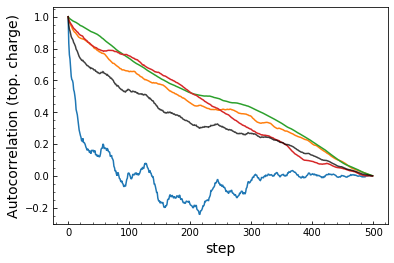

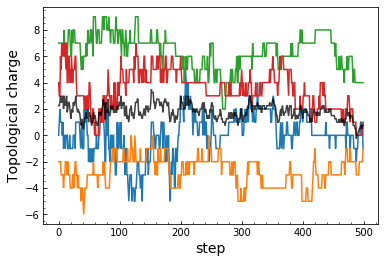

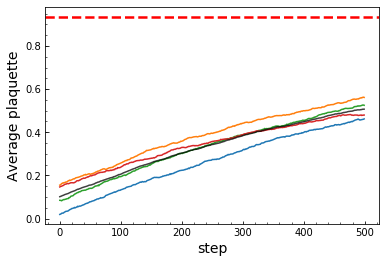

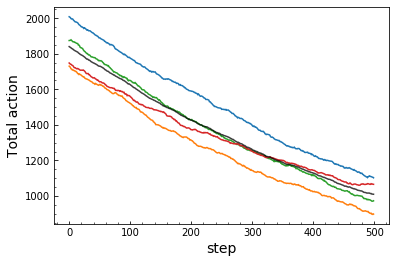

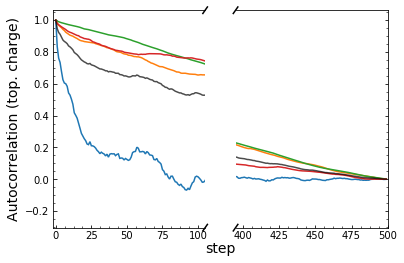

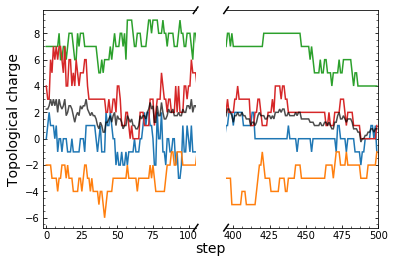

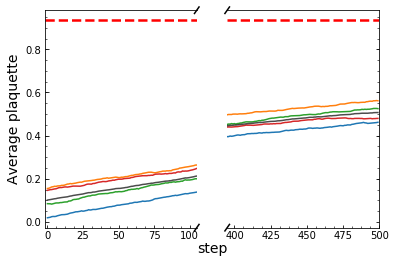

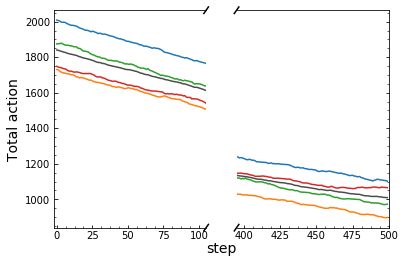

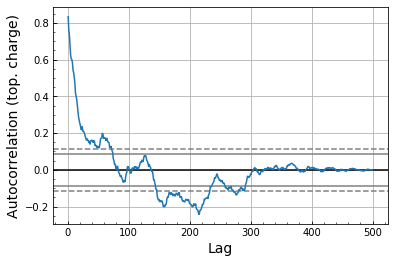

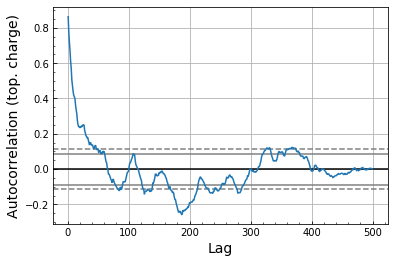

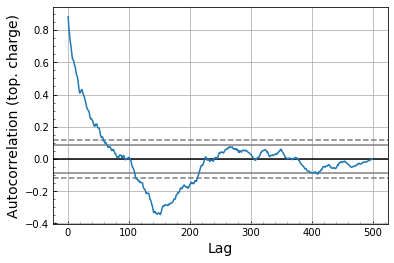

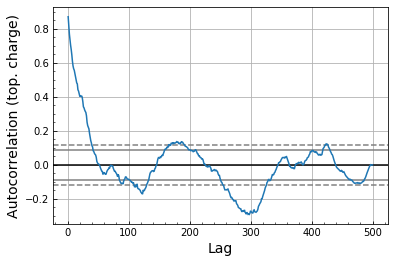

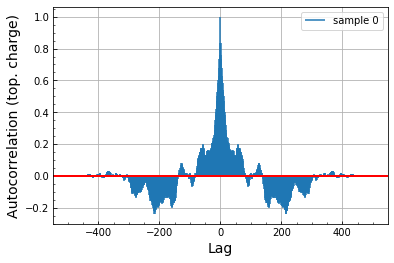

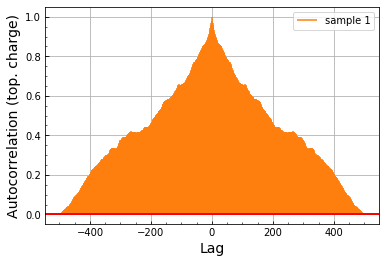

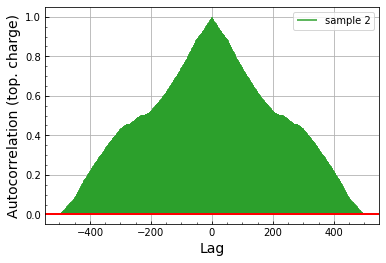

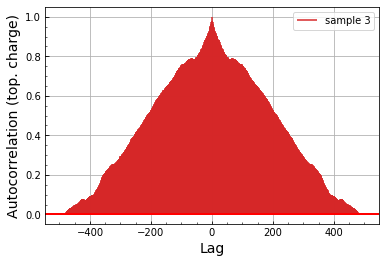

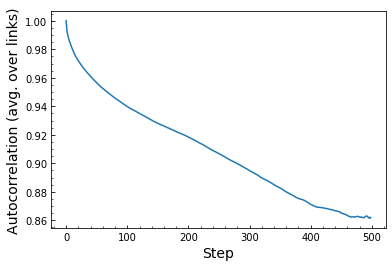

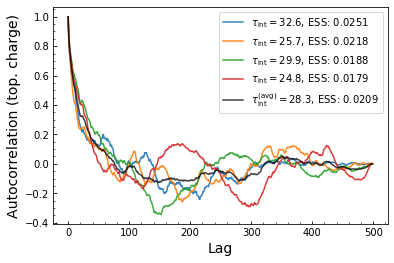

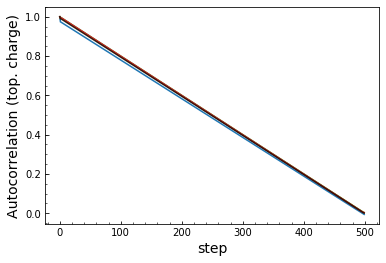

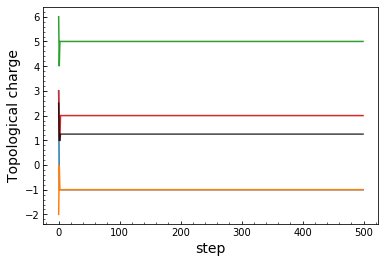

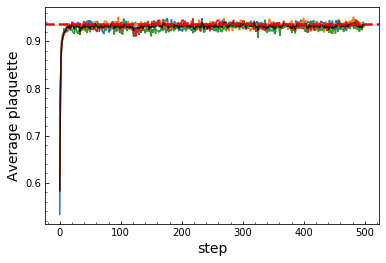

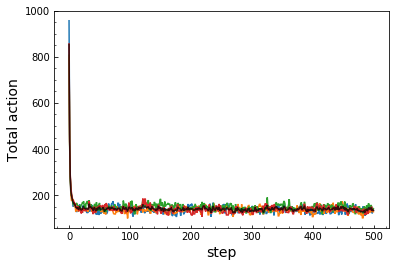

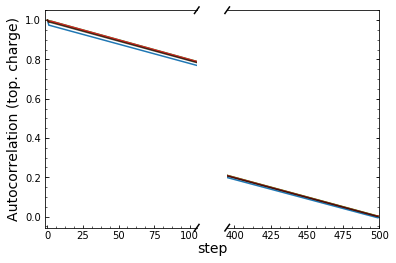

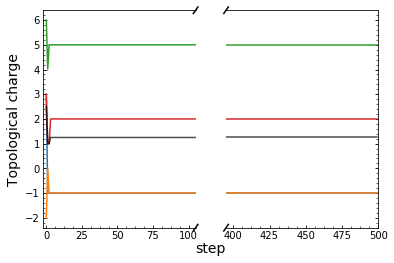

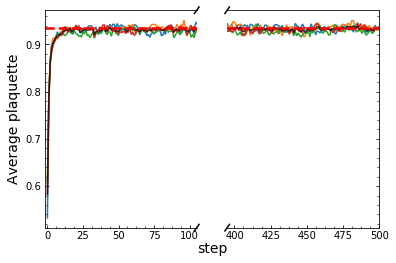

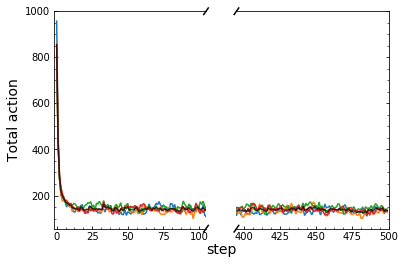

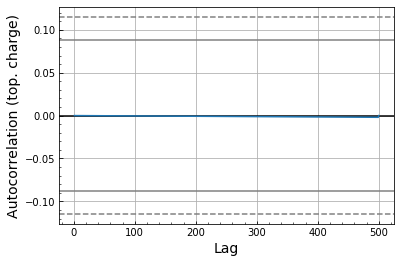

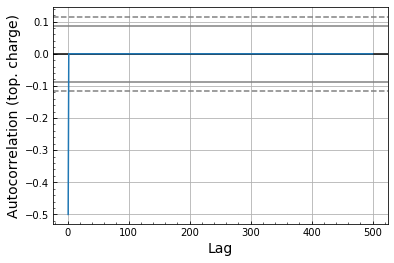

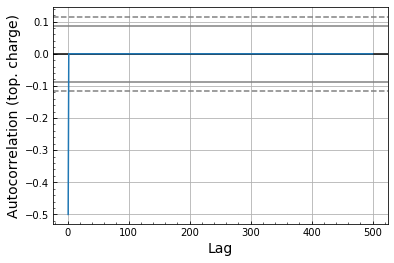

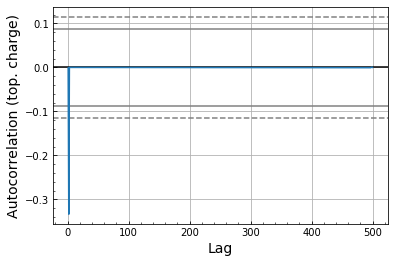

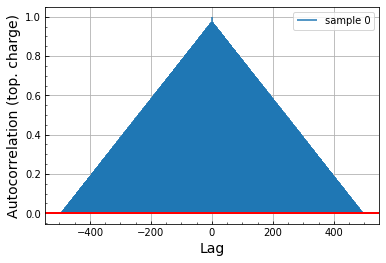

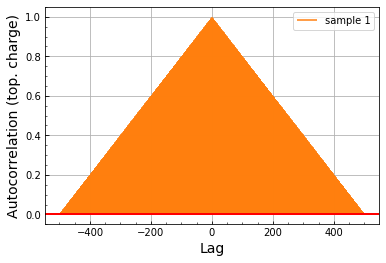

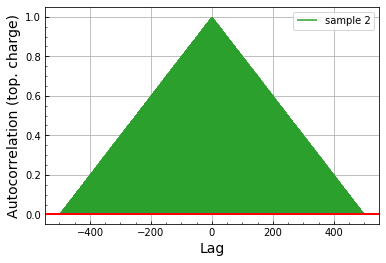

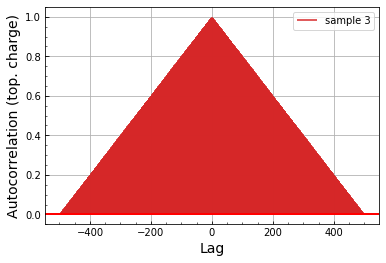

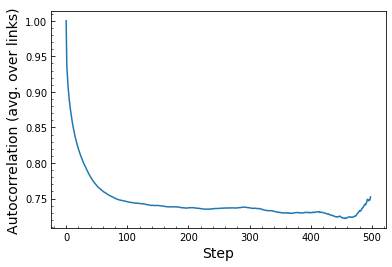

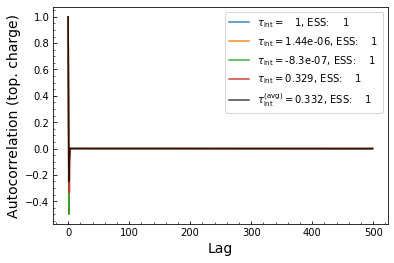

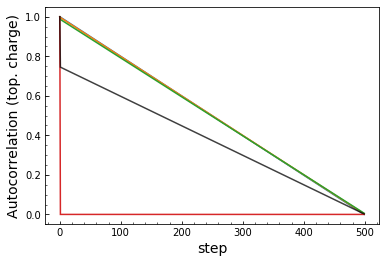

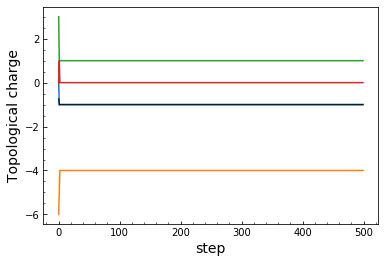

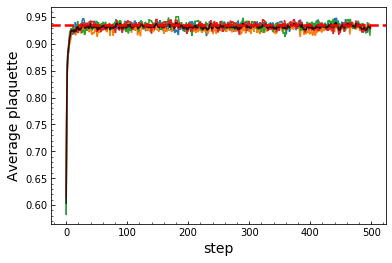

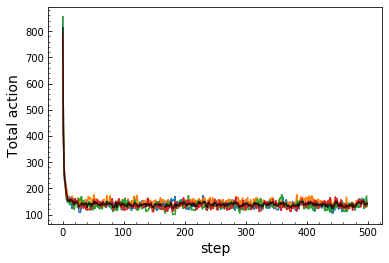

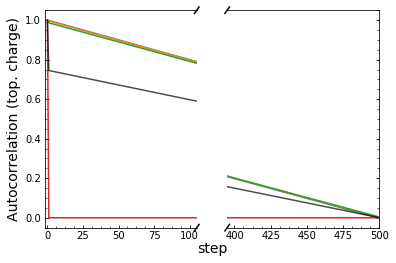

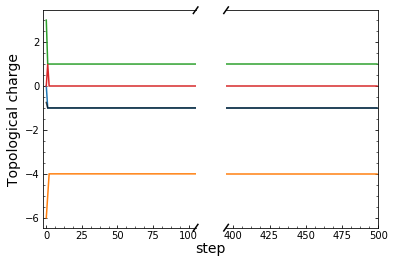

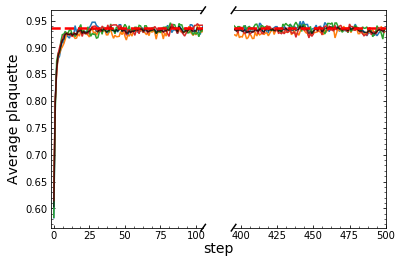

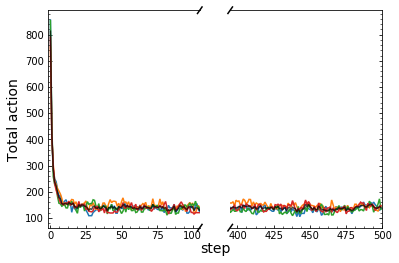

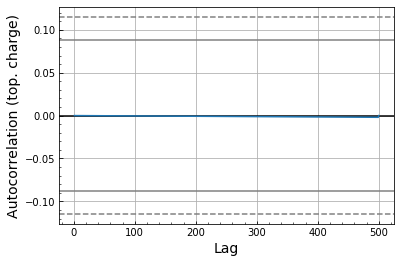

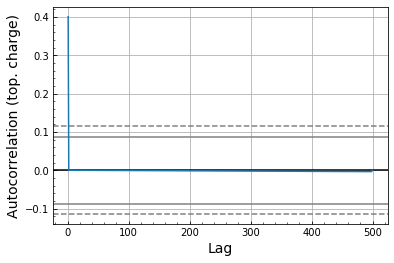

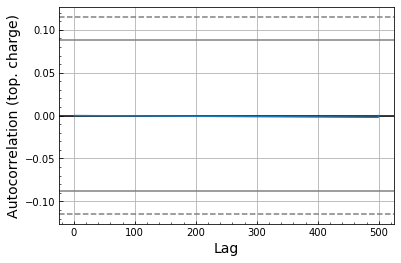

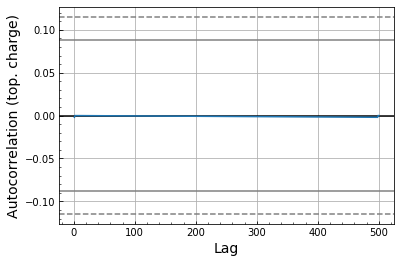

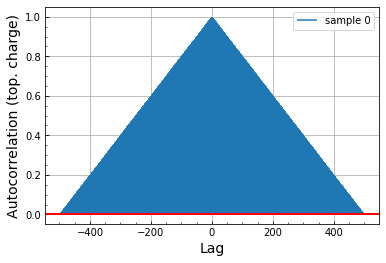

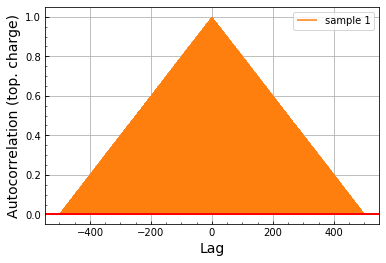

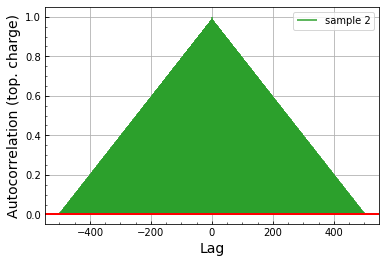

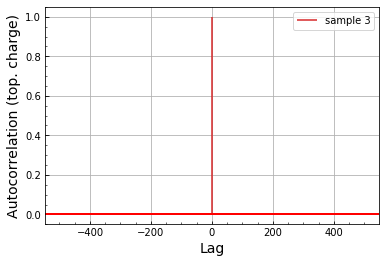

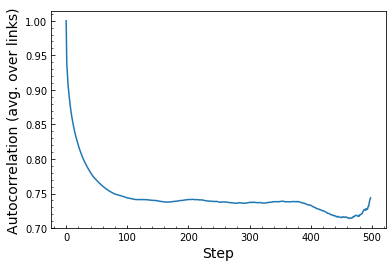

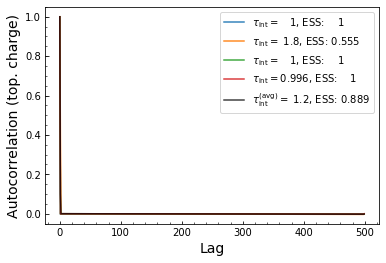

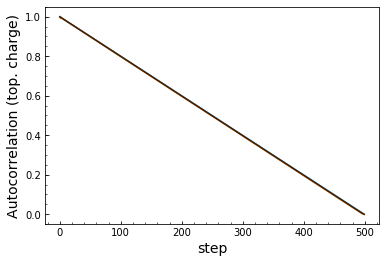

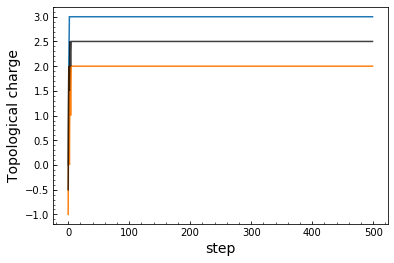

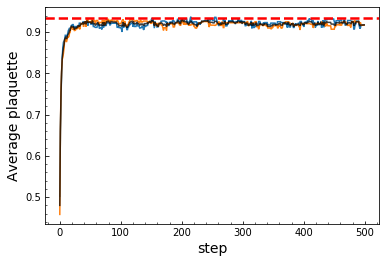

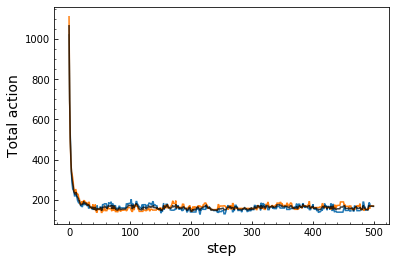

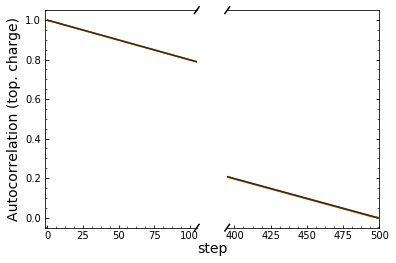

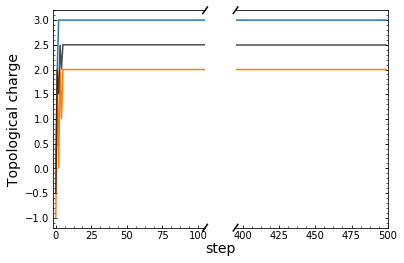

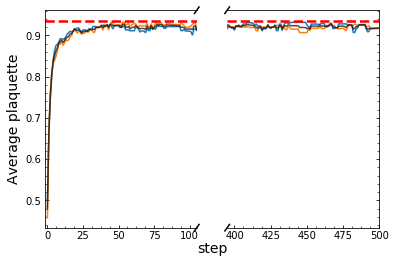

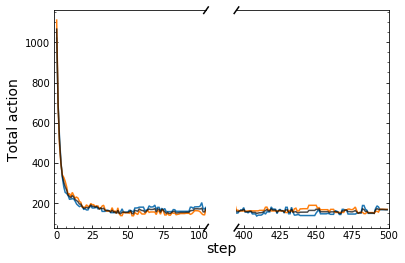

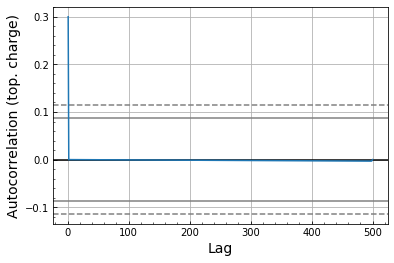

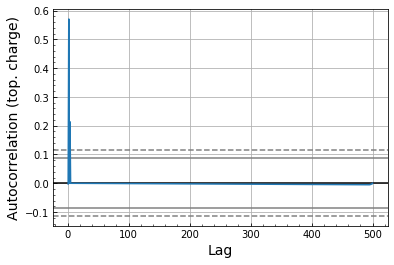

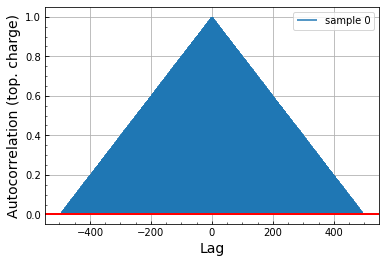

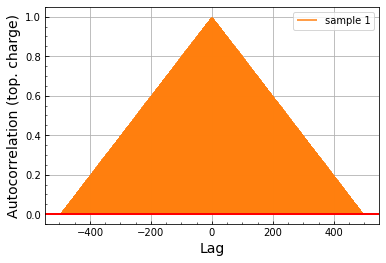

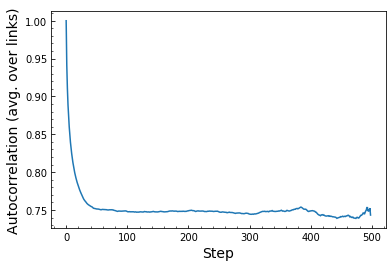

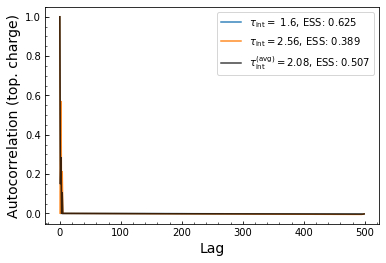

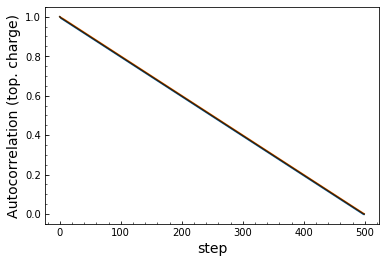

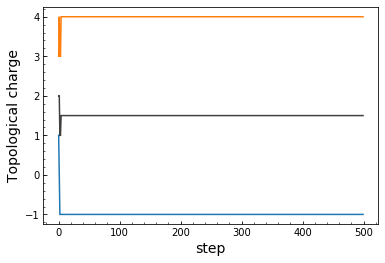

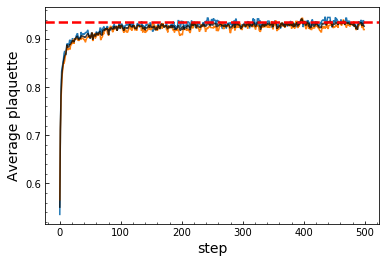

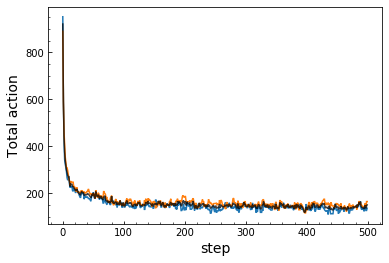

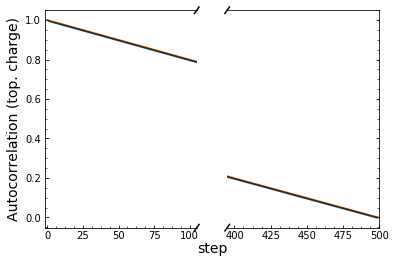

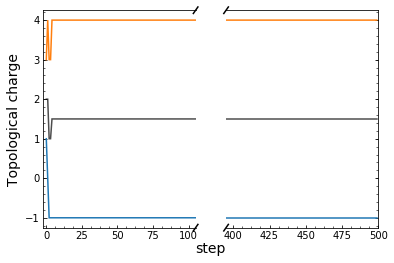

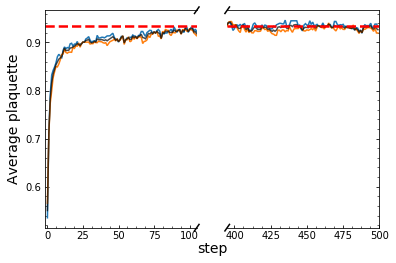

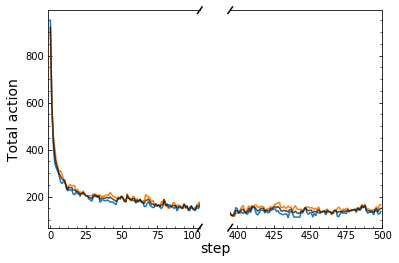

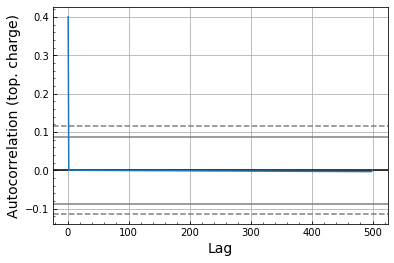

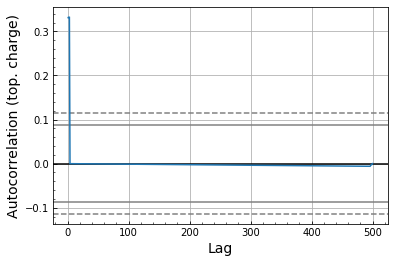

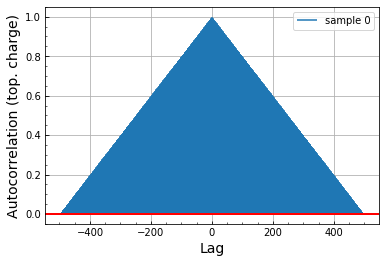

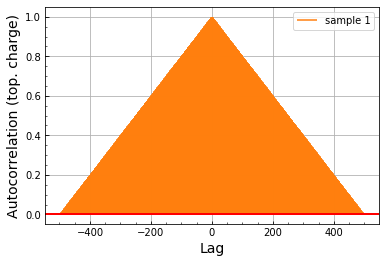

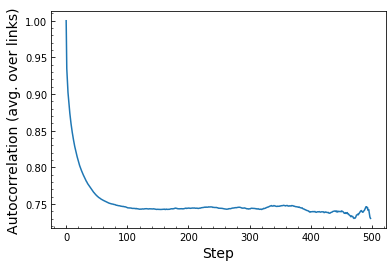

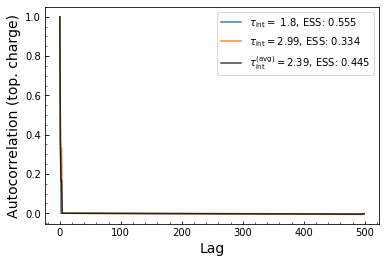

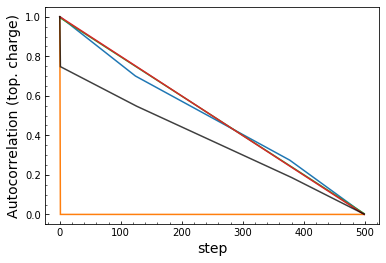

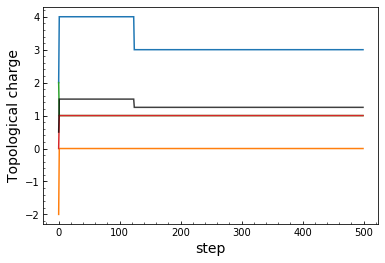

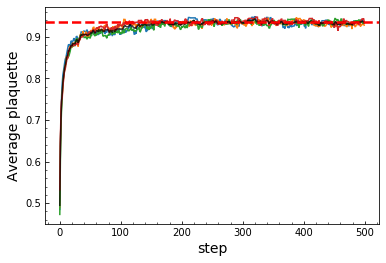

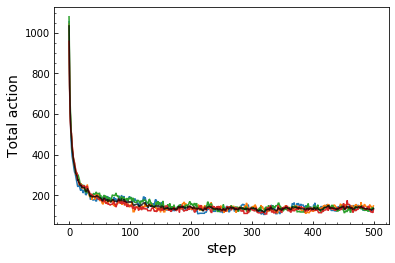

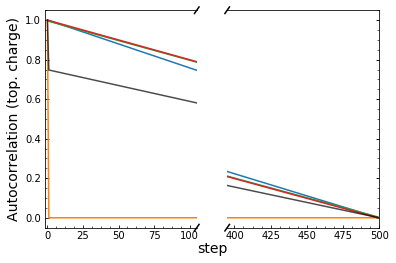

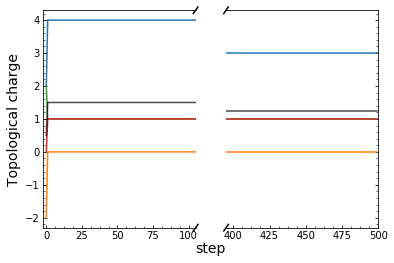

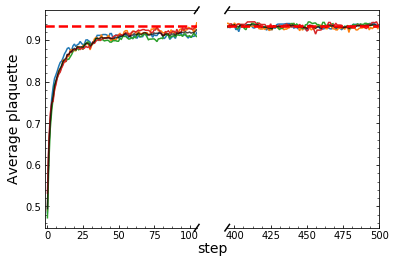

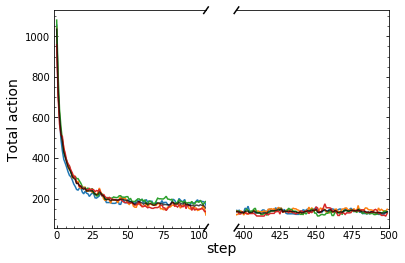

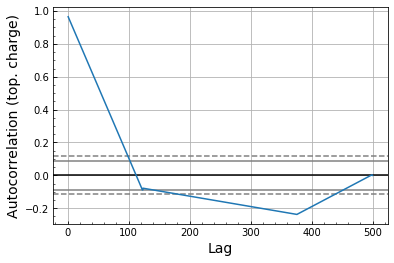

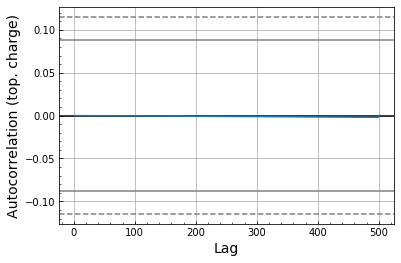

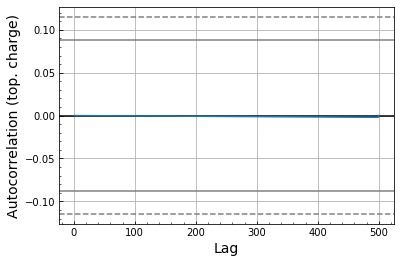

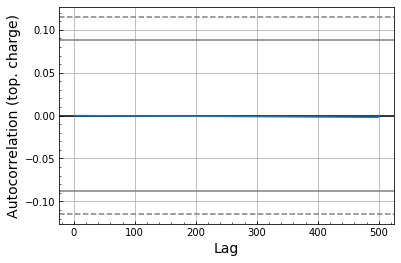

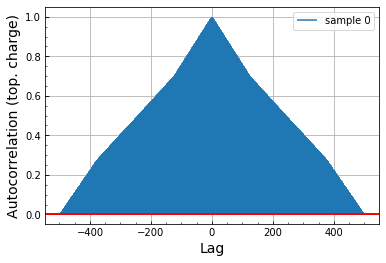

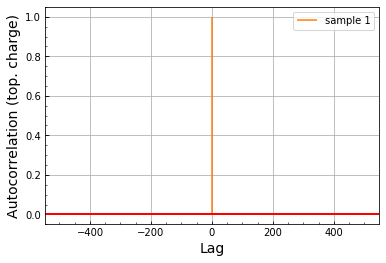

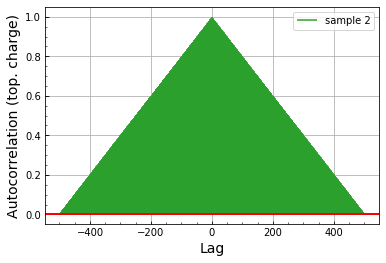

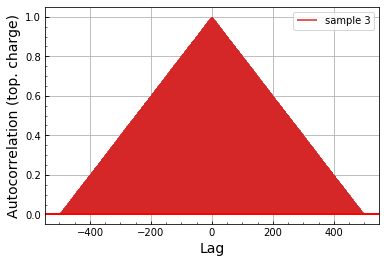

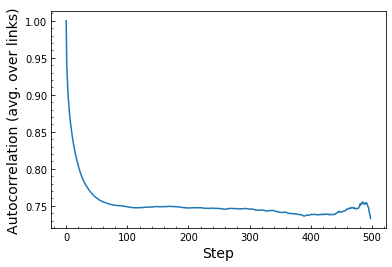

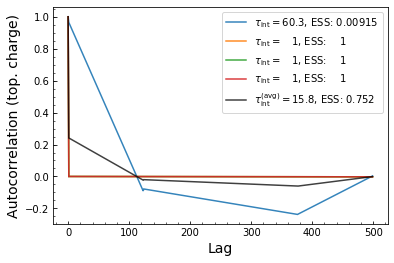

In [8]:
bad_dirs = []
for log_dir in log_dirs:
    try:
        calc_observables_generate_plots(log_dir)
    except:
        bad_dirs.append(log_dir)
        continue

## Calculate observables and create plots step by step, dir by dir...

In [6]:
log_dir = (
    '../../gauge_logs_graph/run_31/'
)

figs_dir = os.path.join(log_dir, 'figures')
autocorr_dir = os.path.join(figs_dir, 'autocorrelation_plots')
pandas_autocorr_dir = os.path.join(
    autocorr_dir, 
    'pandas_autocorrelation_plots'
)
matplotlib_autocorr_dir = os.path.join(
    autocorr_dir, 
    'matplotlib_autocorrelation_plots'
)
check_else_make_dir(autocorr_dir)
check_else_make_dir(matplotlib_autocorr_dir)
check_else_make_dir(pandas_autocorr_dir)

### Calculate observables

In [7]:
from utils.gauge_observables import (
    _load_params, _load_samples, _load_observables
)

In [8]:
params, samples, observables = calc_observables_from_log_dir(log_dir)
if isinstance(observables, dict):
    actions = {}
    avg_plaquettes = {}
    top_charges = {}
    for key, val in observables.items():
        _actions, _avg_plaquettes, _top_charges = val
        actions[key] = _actions
        avg_plaquettes[key] = _avg_plaquettes
        top_charges[key] = _top_charges
else:
    actions, avg_plaquettes, top_charges = observables
    
params

Loading samples history from: ../../gauge_logs_graph/run_31/samples_history/samples_history_500.pkl.
Loading samples history from: ../../gauge_logs_graph/run_31/samples_history/samples_history_1000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_31/samples_history/samples_history_10000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_31/samples_history/samples_history_100.pkl.
Loading samples history from: ../../gauge_logs_graph/run_31/samples_history/samples_history_200.pkl.
Loading samples history from: ../../gauge_logs_graph/run_31/samples_history/samples_history_5000.pkl.
Loading observables from ../../gauge_logs_graph/run_31/observables/observables_200.pkl.
Loading observables from ../../gauge_logs_graph/run_31/observables/observables_100.pkl.
Loading observables from ../../gauge_logs_graph/run_31/observables/observables_10000.pkl.
Loading observables from ../../gauge_logs_graph/run_31/observables/observables_500.pkl.
Loading observables from ../../gauge

{'time_size': 8,
 'space_size': 8,
 'link_type': 'U1',
 'dim': 2,
 'beta': 8.0,
 'num_samples': 6,
 'num_steps': 10,
 'eps': 0.2,
 'loss_scale': 0.1,
 'loss_eps': 0.0001,
 'learning_rate_init': 0.0001,
 'learning_rate_decay_steps': 250,
 'learning_rate_decay_rate': 0.96,
 'train_steps': 5000,
 'save_steps': 100,
 'logging_steps': 25,
 'clip_value': 10,
 'rand': False,
 'metric': 'l2'}

### Calculate autocorr fns, integrated autocorr times (IAT $ = \tau$), and expected sample size (ESS)

In [9]:
if isinstance(top_charges, dict):
    top_charges_autocorr = {}
    top_charges_autocorr_avg = {}
    acf_dict = {}
    iat_dict = {}
    ess_dict = {}
    for key, val in top_charges.items():
        # Previous (naive) method for calculating the top. charges autocorr fn
        _autocorr, _avg = calc_top_charges_autocorr(val)
        top_charges_autocorr[key] = _autocorr
        top_charges_autocorr_avg[key] = _avg
        
        # New (better) method for calculating the top. charges autocorr fn and 
        # integrated autocorrelation time
        acf_arr, iat_arr = calc_integrated_autocorr_time(val)
        
        ess_arr = []
        for acf in acf_arr:
            ess_arr.append(calc_ESS(acf))
            
        acf_dict[key] = acf_arr
        iat_dict[key] = iat_arr
        ess_dict[key] = ess_arr
        
else:
    output = calc_top_charges_autocorr(top_charges)
    top_charges_autocorr, top_charges_autocorr_avg = output

    # New (better) method for calculating the top. charges autocorr fn and 
    # integrated autocorrelation time:
    acf_arr, iat_arr = calc_integrated_autocorr_time(top_charges)

    ESS_arr = []
    for acf in acf_arr:
        ESS_arr.append(calc_ESS(acf))

# Use naive method for calculating autocorr fn. of invidiual links in samples 
if isinstance(samples, dict):
    samples_autocorr_dict = {}
    samples_autocorr_avg_dict = {}
    for key, val in samples.items():
        samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(val)
        
        samples_autocorr_dict[key] = samples_autocorr
        samples_autocorr_avg_dict[key] = samples_autocorr_avg
else:
    samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(samples)

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [5.38978723]

 Failed on idx: 4

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [815.45195771]

 Failed on idx: 0

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [788.55461795]

 Failed on idx: 3

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [516.17819901]

 Failed on idx: 4

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [11.48660886]

 Failed on idx: 0

The chain is sho

/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:42: RuntimeWarning: invalid value encountered in true_divide
  result /= result[result.argmax()]
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:127: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:132: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:71: RuntimeWarning: invalid value encountered in greater
  acl_spectrum = acl_spectrum * (acl_spectrum > 0.05)


### Create plots

In [11]:
figs_dir_dict = {}
for key in observables.keys():
    new_figs_dir = os.path.join(figs_dir, f'figures_{key}')
    if not os.path.isdir(new_figs_dir):
        print(f'Creating directory: {new_figs_dir}.')
        os.makedirs(new_figs_dir)
        
    figs_dir_dict[key] = new_figs_dir

Saving figure to ../../gauge_logs_graph/run_31/figures/figures_500/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_31/figures/figures_500/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_31/figures/figures_500/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_31/figures/figures_1000/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_31/figures/figures_1000/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_31/figures/figures_1000/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_31/figures/figures_10000/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_31/figures/figures_10000/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_31/figures/figures_10000/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_31/figures/figures_100/topological_

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to ../../gauge_logs_graph/run_31/figures/figures_5000/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_31/figures/figures_5000/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_31/figures/figures_5000/integrated_autocorrelation_time_plot.pdf.


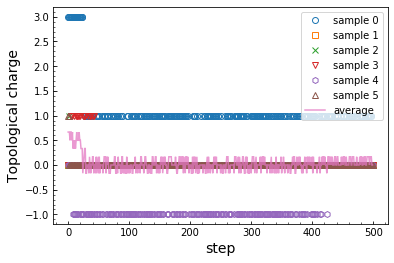

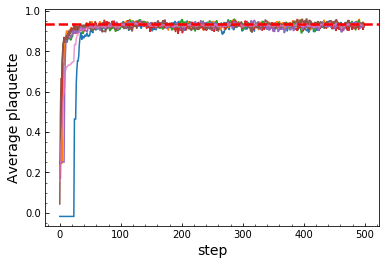

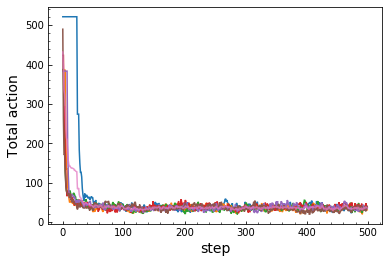

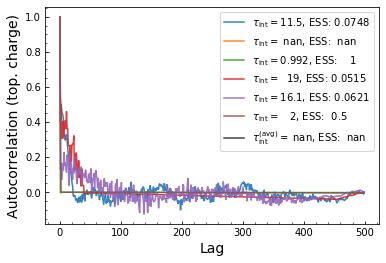

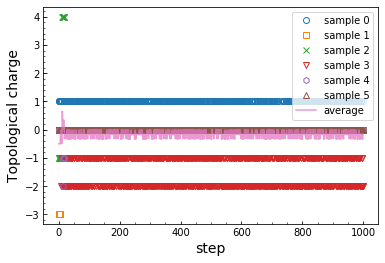

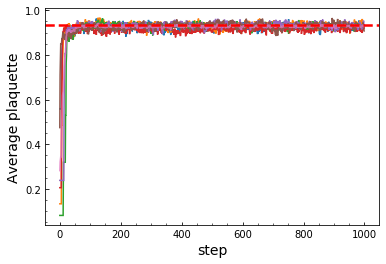

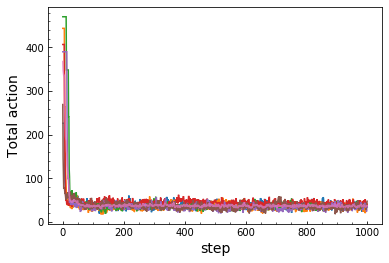

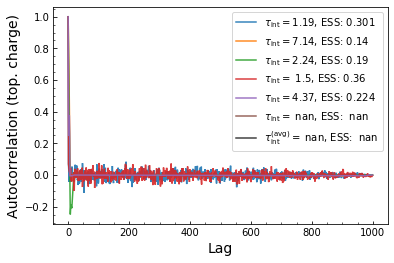

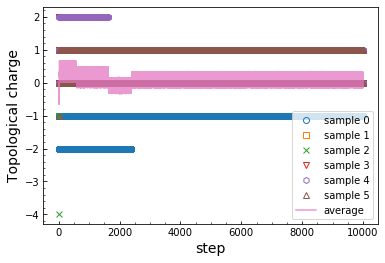

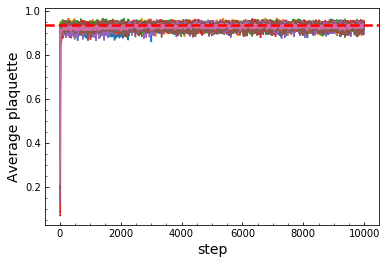

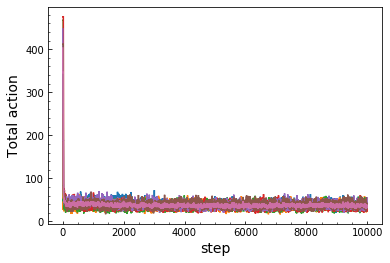

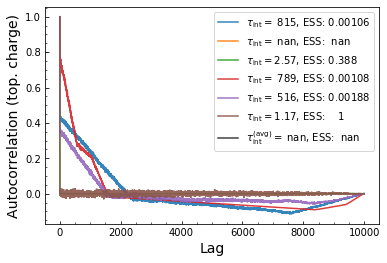

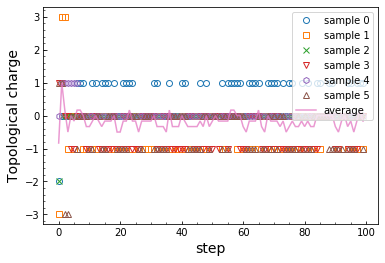

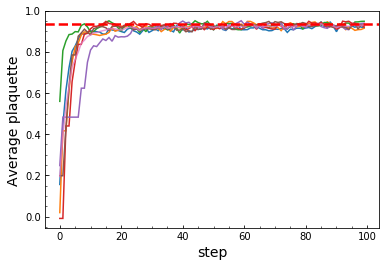

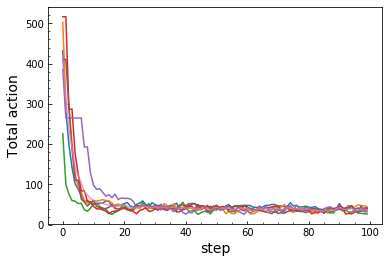

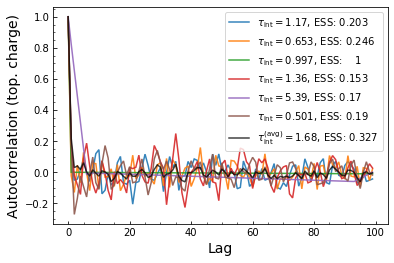

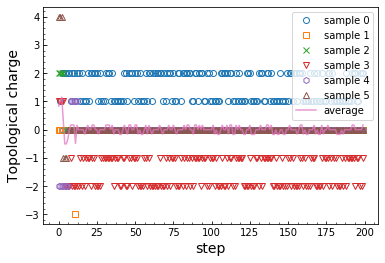

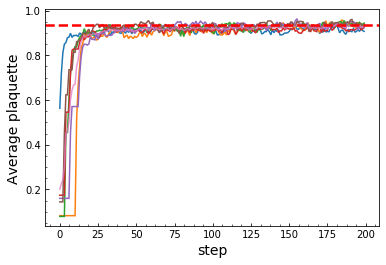

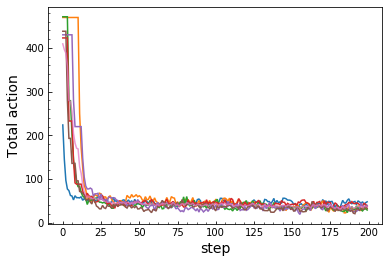

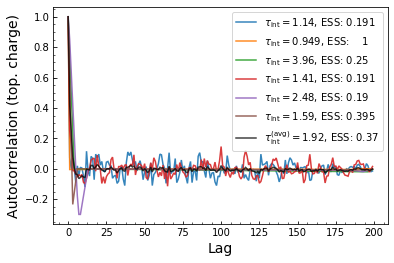

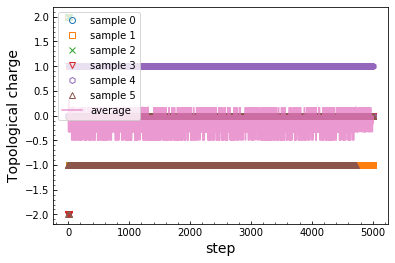

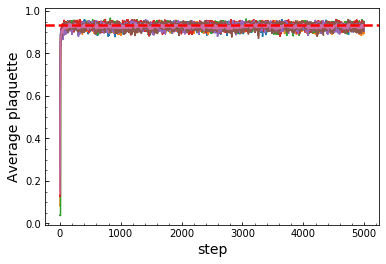

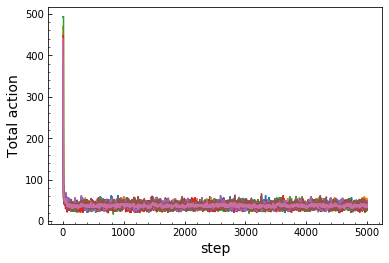

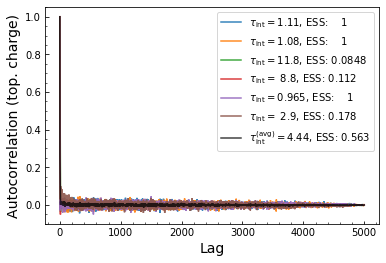

In [115]:
for key in observables.keys():
    _figs_dir = figs_dir_dict[key]
    _actions = actions[key]
    _avg_plaquettes = avg_plaquettes[key]
    _top_charges = top_charges[key]
    _top_charges_autocorr = top_charges_autocorr[key]
    _observables = (_actions, _avg_plaquettes, _top_charges)
    
    figs_axes = make_multiple_lines_plots(
        _figs_dir, 
        params['beta'], 
        _observables
    )
    
    #_ = _plot_individual_observables(
    #    _figs_dir,
    #    _observables,
    #    _top_charges_autocorr
    #)
    
    _acf_arr = acf_dict[key]
    _iat_arr = iat_dict[key]
    _ess_arr = ess_dict[key]
    fig, ax = _plot_individual_acf_iat(_acf_arr, _iat_arr, _ess_arr, _figs_dir)
    

In [1]:
%matplotlib inline

([array([100.]),
  array([100.]),
  array([100.]),
  array([100.]),
  array([100.]),
  array([100.])],
 array([-3.,  3.]),
 <a list of 6 Lists of Patches objects>)

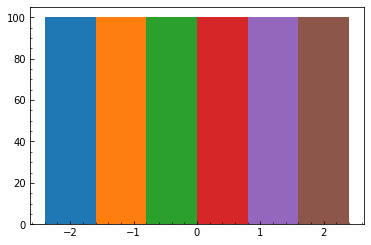

In [21]:
fig, ax = plt.subplots()
ax.hist(top_charges[100], bins=1, range=)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


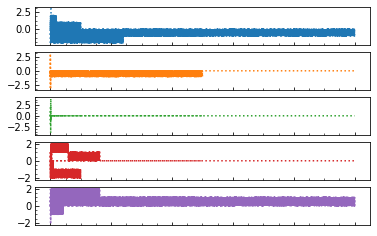

In [16]:
for key, val in top_charges.items():
    ax1 = plt.subplot(511)
    
    _ = plt.plot(val[:, 0], label=f'sample 1', color='C0', ls=':')
                 #markersize=2.5, marker=MARKERS[0], ls=':')
    _ = plt.setp(ax1.get_xticklabels(), visible=False)

    # share x only
    _ = ax2 = plt.subplot(512, sharex=ax1)
    _ = plt.plot(val[:, 1], label=f'sample 2', color='C1', ls=':')
                 #markersize=2.5, marker=MARKERS[1], ls=':')
    _ = plt.setp(ax2.get_xticklabels(), visible=False)

    _ = ax3 = plt.subplot(513, sharex=ax1)
    _ = plt.plot(val[:, 2], label=f'sample 3', color='C2', ls=':')
                 #markersize=2.5, marker=MARKERS[2], ls=':')
    _ = plt.setp(ax3.get_xticklabels(), visible=False)

    _ = ax4 = plt.subplot(514, sharex=ax1)
    _ = plt.plot(val[:, 3], label=f'sample 4', color='C3', ls=':')
                 #markersize=2.5, marker=MARKERS[3], ls=':')
    _ = plt.setp(ax4.get_xticklabels(), visible=False)

    _ = ax5 = plt.subplot(515, sharex=ax1)
    _ = plt.plot(val[:, 4], label=f'sample 5', color='C4', ls=':')
                 #markersize=2.5, marker=MARKERS[4], ls=':')
    _ = plt.setp(ax5.get_xticklabels(), visible=False)

    out_file = os.path.join(figs_dir_dict[key], 'top_charges_sharedx.pdf')
    plt.savefig(out_file, dpi=400, bbox_inches='tight')

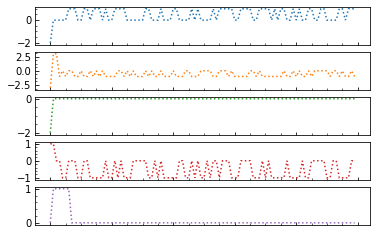

In [15]:
MARKERS = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

ax1 = plt.subplot(511)

_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(512, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(513, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
_ = plt.setp(ax3.get_xticklabels(), visible=False)

_ = ax4 = plt.subplot(514, sharex=ax1)
_ = plt.plot(top_charges[100][:, 3], label=f'sample 4', color='C3', ls=':')
             #markersize=2.5, marker=MARKERS[3], ls=':')
_ = plt.setp(ax4.get_xticklabels(), visible=False)

_ = ax5 = plt.subplot(515, sharex=ax1)
_ = plt.plot(top_charges[100][:, 4], label=f'sample 5', color='C4', ls=':')
             #markersize=2.5, marker=MARKERS[4], ls=':')
_ = plt.setp(ax5.get_xticklabels(), visible=False)

out_file = os.path.join(figs_dir_dict[100], 'top_charges_sharedx.pdf')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [116]:
plt.close('all')

In [111]:
def _plot_individual_observables(figs_dir, observables, top_charges_autocorr):
    multiple_lines_figs_axes = make_multiple_lines_plots(
        figs_dir,
        params['beta'],
        observables,
        top_charges_autocorr,
        legend=False
    )
    return multiple_lines_figs_axes

In [16]:
def _plot_individual_acf_iat(acf_arr, iat_arr, ess_arr, figs_dir):
    out_file = os.path.join(
        figs_dir, 
        'integrated_autocorrelation_time_plot.pdf'
    )
    kwargs = {
        'x_label': 'Lag',
        'y_label': 'Autocorrelation (top. charge)',
        'legend': True,
        'out_file': out_file
    }
    fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ess_arr, **kwargs)
    
    return fig, ax

In [ ]:
# Create plots for observables.
multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

    
# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_autocorr_fn.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_autocorr_fn_broken_xaxis.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/average_action_vs_step_broken_xaxis.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/autocorrelation_plots/pandas_autocorrel

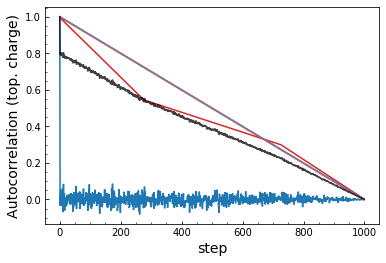

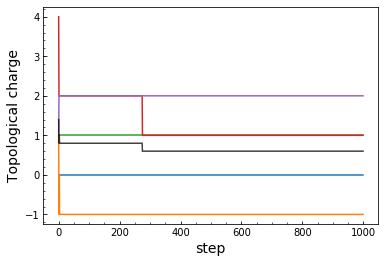

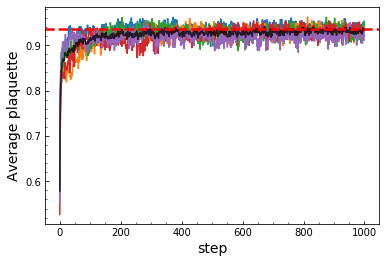

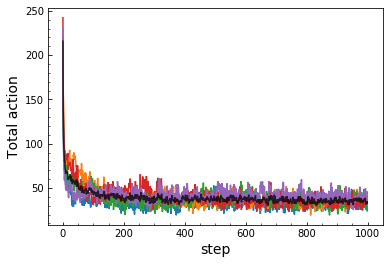

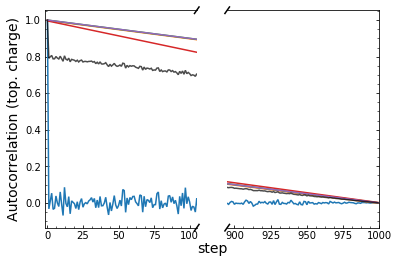

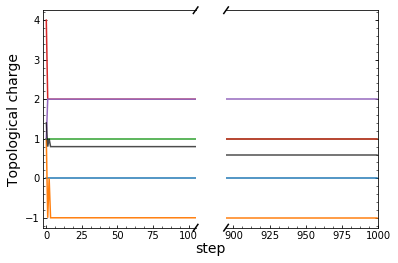

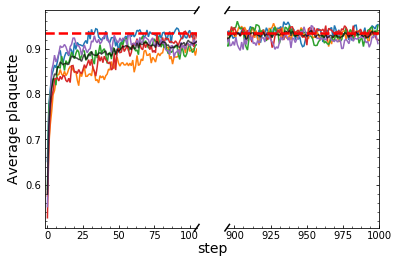

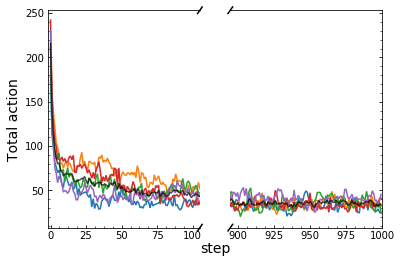

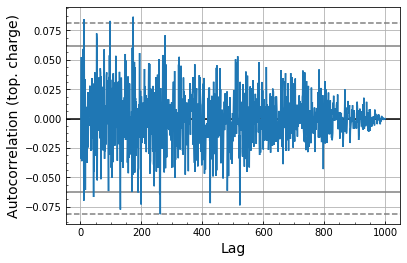

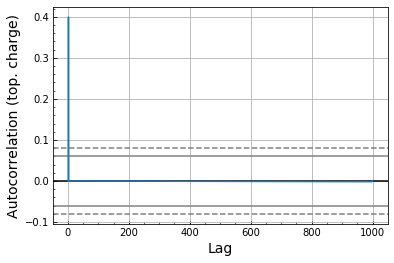

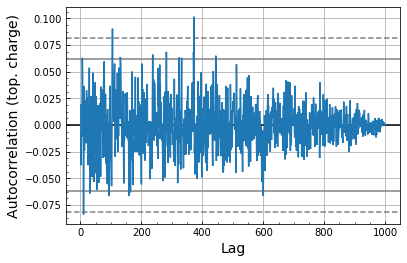

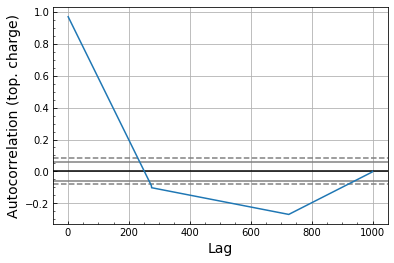

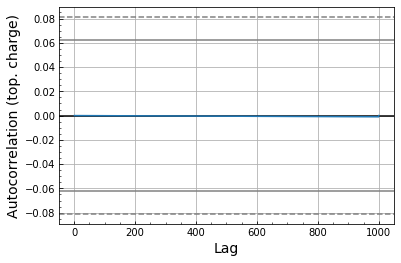

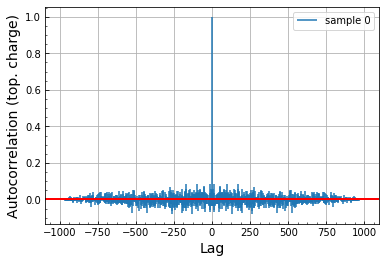

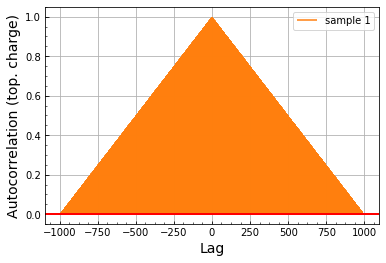

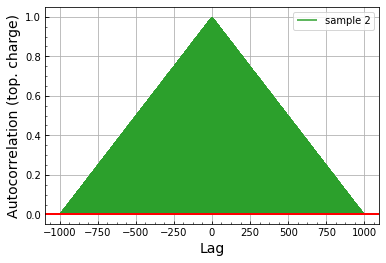

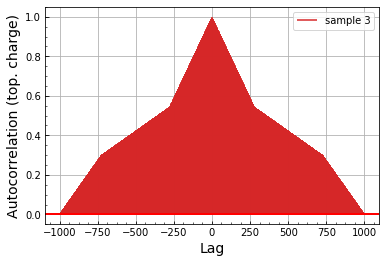

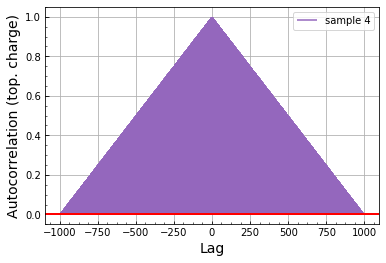

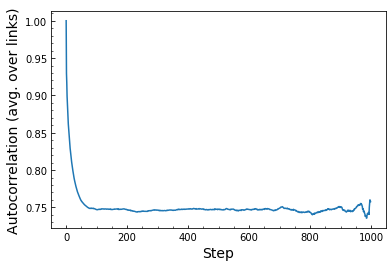

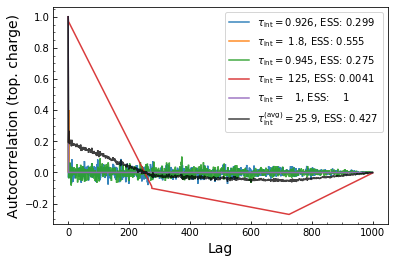

In [8]:
# Create plots for observables.

multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [81]:
plt.close('all')

Saving figure to: ../../gauge_logs_graph/run_19/figures/integrated_autocorrelation_time_plot.pdf.


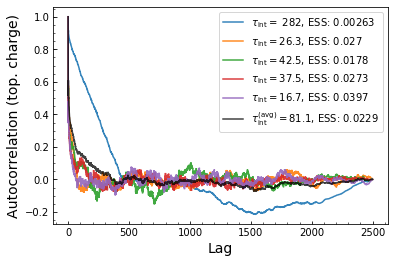

In [24]:
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)

# OLD

In [ ]:
np.mean(ESS_arr)

Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/matplotlib_autocorrelation_plots/top_charges_autocorr_matplotlib.pdf.


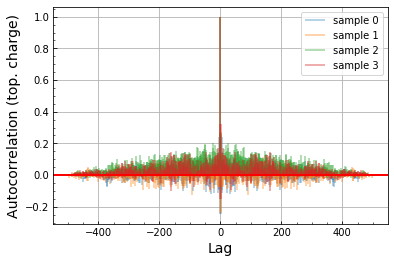

In [224]:
alphas = [0.3, 0.275, 0.25, 0.225, 0.2, 0.175, 
          0.15, 0.125, 0.1, 0.075, 0.05, 0.025][::-1]
out_file = os.path.join(matplotlib_autocorr_dir, 
                        'top_charges_autocorr_matplotlib.pdf')
fig, ax = plt.subplots()
for idx in range(top_charges.shape[1]):
    output = ax.acorr(top_charges[:, idx], usevlines=True, color=COLORS[idx],
                      normed=True, maxlags=None,
                      alpha=alphas[idx]+0.4, #zorder=zorders[idx],
                      label=f'sample {idx}')

_ = ax.axhline(0, color='r', lw=2)
_ = ax.grid(True)
_ = ax.legend(loc='best')
    
_ = ax.set_xlabel("Lag", fontsize=14)
_ = ax.set_ylabel("Autocorrelation (top. charge)", fontsize=14)
print(f'Saving figure to: {out_file}.')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [300]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 5, False)

In [301]:
lattice.num_links

128

##### Old approach (unsure of validity)

In [25]:
len_by_4 = len(top_charges) // 4
len_by_2 = len(top_charges) // 2
len_by_10 = len(top_charges) // 10
kappa4 = len(top_charges) - len_by_4
kappa2 = len(top_charges) - len_by_2
kappa10 = len(top_charges) - len_by_10
iac2, autocorr2 = calc_iat(top_charges.mean(axis=1), kappa=kappa2)
iac4, autocorr4 = calc_iat(top_charges.mean(axis=1), kappa=kappa4)
iac10, autocorr10 = calc_iat(top_charges.mean(axis=1), kappa=kappa10)

In [26]:
iac2, iac4, iac10

(2.1520862694468614, 1.5014179402207577, 1.9374474465140532)

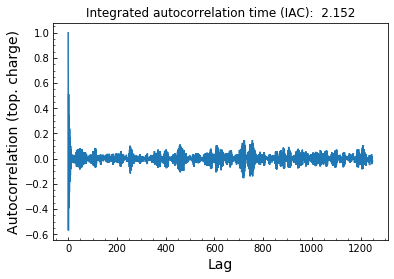

In [27]:
out_file = os.path.join(autocorr_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa2}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr2)), autocorr2, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac2:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

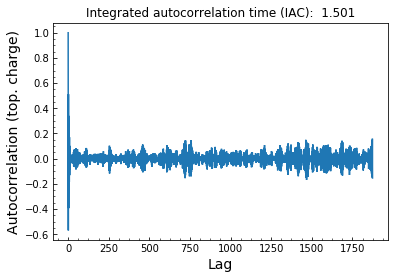

In [28]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa4}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr4)), autocorr4, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac4:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

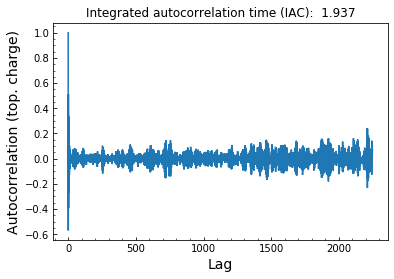

In [29]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa10}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr10)), autocorr10, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac10:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

## Old method (make each plot by hand)

### Specify run directory containing parameters and samples 

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)

In [ ]:
# Create lattice with same parameters to use for calculating observables
lattice = GaugeLattice(params['time_size'],
                       params['space_size'],
                       params['dim'],
                       params['beta'],
                       params['link_type'],
                       params['num_samples'],
                       params['rand'])

In [ ]:
# Load samples from `info_dir/samples_history.pkl` file
# Note that samples_history will be an array of shape:
#    [num_samples, num_eval_steps]
# where num_samples is the number of samples in each batch
# and num_eval steps is the number of steps the (trained) L2HMC simulation 
# was ran for.
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
with open(samples_history_file, 'rb') as f:
    samples_history = pickle.load(f)

In [ ]:
np.array(samples_history).shape

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
samples_history = np.array(samples_history)
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)
steps = np.arange(len(actions_history))

In [ ]:
len(samples_history[0].shape)

In [ ]:
# Compute the autocorrelation function using the topological charges
top_charges_autocorr_arr = []
num_samples = top_charges_history.shape[1]
for i in range(num_samples):
    top_charges_autocorr_arr.append(autocorr(top_charges_history[:, i]))
top_charges_autocorr_arr = np.array(top_charges_autocorr_arr)
top_charges_autocorr_avg = np.mean(top_charges_autocorr_arr, axis=0)

In [ ]:
top_charges_autocorr_arr.shape

In [ ]:
top_charges_autocorr_avg.shape

In [ ]:
samples_history = np.array(samples_history)
_shape = samples_history.shape
samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
num_samples = samples_history.shape[1]
num_links  = samples_history.shape[-1]
samples_autocorr_arr = []
for n in range(num_samples):
    links_autocorr_arr = []
    for l in range(num_links):
        links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
    samples_autocorr_arr.append(links_autocorr_arr)
samples_autocorr_arr = np.array(samples_autocorr_arr)
samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)

In [ ]:
samples_history.shape

In [ ]:
samples_autocorr_arr.shape

In [ ]:
samples_autocorr_arr_avg.shape

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_autocorr_fn.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_autocorr_arr,
                              x_label='step', 
                              y_label='Autocorrelation (top. charge)',
                              legend=True,
                              out_file=out_file)

In [ ]:
len(steps)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_autocorr_fn_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_autocorr_arr.T,
                                 xlabel='step',
                                 ylabel='Autocorrelation (top. charge)',
                                 #xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_history.T,
                              x_label='step', y_label='Topological charge',
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_history,
                                 xlabel='step', ylabel='Topological charge',
                                 xlim1=(-2, 100), xlim2=(895, 1000),
                                 output_file=None)
ax2.legend(loc='lower right')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
from lattice.gauge_lattice import u1_plaq_exact

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, avg_plaquettes_history.T,
                              x_label='step', y_label='Average plaquette')
_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, avg_plaquettes_history,
                                 xlabel='step', ylabel='Average plaquette',
                                 xlim1=(-2, 65), xlim2=(895, 1000),
                                 output_file=None)

_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

_ = ax2.axhline(y=u1_plaq_exact(params['beta']), 
                color='r', ls='--', lw=2.5, label='exact')
leg = ax2.legend(loc='lower right', fontsize=10)

plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, actions_history.T,
                              x_label='step', y_label='Average plaquette')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, actions_history,
                                 xlabel='step', ylabel='Total action',
                                 xlim1=(-2, 55), xlim2=(895, 1000),
                                 output_file=out_file)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)
acl_steps = np.arange(len(samples_acl_spectrum))
fig, ax = plt.subplots()
ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0])
ax.set_xlabel('step', fontsize=14)
ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
            dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
from utils.gauge_observables import *

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'

In [ ]:
params, samples, observables = calc_observables_from_log_dir(log_dir)

In [ ]:
actions, avg_plaquettes, top_charges = observables

beta = params['beta']
figs_dir = os.path.join(log_dir, 'figures')

In [ ]:
top_charges_autocorr, _ = calc_top_charges_autocorr(top_charges)
samples_autocorr, _ = calc_samples_autocorr(samples)

In [ ]:
from utils.gauge_observables import _make_plots

In [ ]:
multiple_lines_figs_axes, broken_xaxis_figs_axes = _make_plots(
    figs_dir, 
    beta, 
    samples, 
    observables,
    top_charges_autocorr, 
    samples_autocorr
)

In [ ]:
make_plots_from_log_dir(log_dir)

## Compare Sample Autocorrelation across runs

In [ ]:
_dir = '../../gauge_logs_graph/'
dirs = [
    os.path.join(_dir, i) for i in os.listdir(_dir) if i .startswith('run')
]

In [ ]:
samples_dict = {}
params_dict = {}
lattice_dict = {}
for d in dirs:
    key = d.split('/')[-1]
    info_dir = os.path.join(d, 'run_info')
    samples_file = os.path.join(info_dir, 'samples_history.pkl')
    parameters_file = os.path.join(info_dir, 'parameters.pkl')
    try:
        with open(samples_file, 'rb') as f:
            samples_dict[key] = pickle.load(f)
        with open(parameters_file, 'rb') as f:
            params_dict[key] = pickle.load(f)
        lattice_dict[key] = GaugeLattice(time_size=params['time_size'],
                                         space_size=params['space_size'],
                                         dim=params['dim'],
                                         beta=params['beta'],
                                         link_type=params['link_type'],
                                         num_samples=params['num_samples'],
                                         rand=params['rand'])
    except FileNotFoundError:
        continue

In [ ]:
samples_autocorr_dict = {}
samples_autocorr_avg_dict = {}
samples_acl_spectrum_dict = {}
for key, samples_history in samples_dict.items():
    samples_history = np.array(samples_history)
    _shape = samples_history.shape
    samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
    num_samples = samples_history.shape[1]
    num_links  = samples_history.shape[-1]
    samples_autocorr_arr = []
    for n in range(num_samples):
        links_autocorr_arr = []
        for l in range(num_links):
            links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
        samples_autocorr_arr.append(links_autocorr_arr)
    samples_autocorr_arr = np.array(samples_autocorr_arr)
    samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)
    samples_autocorr_dict[key] = samples_autocorr_arr
    samples_autocorr_avg_dict[key] = samples_autocorr_arr_avg
    samples_acl_spectrum_dict[key] = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_autocorr_avg_dict['run_37'].mean(axis=0).shape

In [ ]:
fig, ax = plt.subplots()
for key, samples_autocorr_avg in samples_autocorr_avg_dict.items():
    autocorr_avg_over_samples = samples_autocorr_avg.mean(axis=0)
    steps = np.arange(len(autocorr_avg_over_samples))
    _ = ax.plot(steps, autocorr_avg_over_samples, label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
_ = plt.show()

In [ ]:
fig, ax = plt.subplots()
for key, samples_acl_spectrum in samples_acl_spectrum_dict.items():
    acl_steps = np.arange(len(samples_acl_spectrum))
    _ = ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0], 
                label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
#plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
#            dpi=400, bbox_inches='tight')
plt.show()

### Incorrect

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum.pdf')
fig, ax = plot_multiple_lines(x_data=steps, 
                              y_data=samples_autocorr_arr[0, 0:20],
                              x_label='step',
                              y_label='Autocorrelation (links)',
                              legend=False,
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum_avg.pdf')
fig, ax = plot_multiple_lines(x_data=steps,
                              y_data=samples_autocorr_arr_avg,
                              x_label='step',
                              y_label='Autocorrelation (avg. over links)',
                              semilogy=False,
                              legend=True,
                              out_file=out_file)

## OLD

In [ ]:
tf.InteractiveSession.close

In [ ]:
tf.Session().close()

In [ ]:
#sess = tf.InteractiveSession()

In [ ]:
tf.reset_default_graph()

In [ ]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 2, rand=False)

In [ ]:
samples = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
potential_fn = lattice.get_energy_function(samples)

In [ ]:
dynamics = gde.GaugeDynamicsEager(
    lattice=lattice,
    num_steps=5,
    eps=0.1,
    minus_loglikelihood_fn=potential_fn,
    conv_net=True,
    hmc=False,
    eps_trainable=True
)

In [ ]:
# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

In [ ]:
# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_element = iterator.get_next()

In [ ]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [ ]:
# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
for _ in range(20):
  # Initialize an iterator over the training dataset.
  sess.run(training_init_op)
  for _ in range(10):
    sess.run(next_element)

  # Initialize an iterator over the validation dataset.
  sess.run(validation_init_op)
  for _ in range(5):
    sess.run(next_element)

In [ ]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"

In [ ]:
samples_placeholder = tf.placeholder(samples.dtype, samples.shape)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(samples_placeholder).batch(2)

In [ ]:
dataset.output_shapes

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(dynamics.apply_transition(samples_placeholder))

In [ ]:
dataset.apply(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [ ]:
sess.run(iterator.initializer, feed_dict={samples_placeholder: samples})

In [ ]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)    # Take a placeholder to create a dataset
iterator = dataset.make_initializable_iterator()      # Create an initializable iterator
next_element = iterator.get_next()

with tf.Session() as sess:
    # Initialize an iterator over a dataset with 10 elements using placeholder.
    sess.run(iterator.initializer, feed_dict={max_value: 10}) 

    for i in range(10):
        value = sess.run(next_element)
        print(f"{value} ", end=" ")    # 0 1 2 3 ... 9

In [ ]:
dataset = tf.data.Dataset.from_tensors(samples_placeholder)

In [ ]:
dataset

In [ ]:
dataset.apply(dynamics.apply_transition)
dataset = dataset.map(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()

In [ ]:
sess.run(iterator.initializer, 
         feed_dict={samples_placeholder: lattice.samples})

In [ ]:
next_element = iterator.get_next()

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
sess.run(result)

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

In [ ]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})